# CaBoost Classification Obesity Level

## Importing the libraries

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lime.lime_tabular import LimeTabularExplainer
import dice_ml
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import time
from IPython.display import display

## Importing the dataset

In [ ]:
try:
    df = pd.read_csv('DataObesity_Test.csv')
    df3 = pd.read_csv('Dhaka_Obesity.csv')
except FileNotFoundError:
    print("File 'DataObesity_Test.csv' tidak ditemukan. Pastikan Anda sudah mengunduhnya dari Kaggle.")
    exit()

## Preprocessing Data

### Data Cleaning

In [ ]:
# --- Data Cleaning for df ---
print("--- Cleaning Dataframe 'df' ---")
# Cek missing values pada df
print("Missing values in df:")
print(df.isnull().sum())

# Cek duplikasi pada df
print("\nChecking for duplicates in df:")
initial_rows_df = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_dropping_df = df.shape[0]
dropped_duplicates_df = initial_rows_df - rows_after_dropping_df
print(f"Number of duplicate rows dropped from df: {dropped_duplicates_df}")

print("\nInfo after cleaning df:")
df.info()

# --- Data Cleaning for df3 ---
print("\n--- Cleaning Dataframe 'df3' ---")
# Cek missing values pada df3
print("Missing values in df3:")
print(df3.isnull().sum())

# Cek duplikasi pada df3
print("\nChecking for duplicates in df3:")
initial_rows_df3 = df3.shape[0]
df3.drop_duplicates(inplace=True)
rows_after_dropping_df3 = df3.shape[0]
dropped_duplicates_df3 = initial_rows_df3 - rows_after_dropping_df3
print(f"Number of duplicate rows dropped from df3: {dropped_duplicates_df3}")

print("\nInfo after cleaning df3:")
df3.info()

--- Cleaning Dataframe 'df' ---
Missing values in df:
Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Checking for duplicates in df:
Number of duplicate rows dropped from df: 24

Info after cleaning df:
<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  ---

### Transformation Data

In [ ]:
df['Height'] = df['Height'] * 100
df3['Height (m)'] = df3['Height (m)'] * 100

In [ ]:
print("--- TIPE DATA LAMA ---")
print(df.dtypes)
kolom_float = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

for kolom in kolom_float:
    df[kolom] = df[kolom].astype('int64')

print("\n\n--- TIPE DATA BARU ---")
print(df.dtypes)

--- TIPE DATA LAMA ---
Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


--- TIPE DATA BARU ---
Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC          

In [ ]:
#DataObesity_Test
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce').fillna(0).astype(int)
df['Height'] = pd.to_numeric(df['Height'], errors='coerce').fillna(0).astype(int)

#Dhaka_Obesity
df3['Weight (kg)'] = pd.to_numeric(df3['Weight (kg)'], errors='coerce').fillna(0).astype(int)
df3['Height (m)'] = pd.to_numeric(df3['Height (m)'], errors='coerce').fillna(0).astype(int)

In [ ]:
print("DataObesity_Test")
print(df.info())
print("\n")
print("Dhaka_Obesity")
print(df3.info())

DataObesity_Test
<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2087 non-null   float64
 1   Gender                          2087 non-null   object 
 2   Height                          2087 non-null   int64  
 3   Weight                          2087 non-null   int64  
 4   CALC                            2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   int64  
 7   NCP                             2087 non-null   int64  
 8   SCC                             2087 non-null   object 
 9   SMOKE                           2087 non-null   object 
 10  CH2O                            2087 non-null   int64  
 11  family_history_with_overweight  2087 non-null   object 
 12  FAF                   

### Checking Data

In [ ]:
# Mengidentifikasi data unik di setiap kolom non-angka (object)
print("--- NILAI UNIK DI SETIAP KOLOM NON-ANGKA (OBJECT) ---")
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Kolom '{column}': {unique_values}")

--- NILAI UNIK DI SETIAP KOLOM NON-ANGKA (OBJECT) ---
Kolom 'Age': [21.       23.       27.       ... 22.524036 24.361936 23.664709]
Kolom 'Gender': ['Female' 'Male']
Kolom 'Height': [162 152 180 178 150 164 172 185 165 177 170 193 153 171 169 160 175 168
 158 179 156 167 166 181 182 155 161 163 176 157 188 187 189 174 183 192
 173 184 191 148 159 154 190 186 145 198 151 149 194 197]
Kolom 'Weight': [ 64  56  77  87  89  53  55  68 105  80  99  60  66 102  78  82  70  50
  65  52  76  83  90  62  49  48  67  88  75  72  54  44  58  57  69  95
 112  85  45  91  93  84  42  63  51  86  61 109  59  94 130  79  96  98
  74 118  40  71 100  73 114 121 120  47  81 115 107 110 173  97 125  92
 108  39 113 104 126 137 165 133 111  43  41  46 101 106 103 116 117 128
 122 129 124 119 123 127 149 131 152 132 142 135 138 155 141 151 144 154
 160 136 140 134 153 147 150]
Kolom 'CALC': ['no' 'Sometimes' 'Frequently' 'Always']
Kolom 'FAVC': ['no' 'yes']
Kolom 'FCVC': [2 3 1]
Kolom 'NCP': [3 1 4 2]
Ko

In [ ]:
# Mengidentifikasi data unik di setiap kolom non-angka (object)
print("--- NILAI UNIK DI SETIAP KOLOM NON-ANGKA (OBJECT) ---")
for column in df3.columns:
    unique_values = df3[column].unique()
    print(f"Kolom '{column}': {unique_values}")

--- NILAI UNIK DI SETIAP KOLOM NON-ANGKA (OBJECT) ---
Kolom 'Gender': ['Male' 'Female']
Kolom 'Age': [29 25 23 22 19 24 30 16 32 18 26 20 44 21 34 36 28 52 51 37 35 27 40 41
 31 58 46 39 17 59 33 45 15 54 38 50 49 42 48 62 43 61 60 75 53 47 56 55
 57 67 70 65]
Kolom 'Height (m)': [165 170 168 175 155 157 183 180 173 163 160 142 152 145 140 178 188 137
 147 185 135 150 130 132 122]
Kolom 'Weight (kg)': [101  53  70 112  67  90  73 110  49  46  43  69  52  75  60  92  88 120
  65 105  61  77  78  64  51  91  45  47 107  82  80  96 104  62  98  94
  58 109  55 103  48  50  85  40  99  41 113  81 117  44 106  54  71  97
  72  38 100  63  68  76  93  86  89  95 115  42  56 116  74  87  79  59
  66 118 114  57  84 102 119  83 130 127 108  35 123  39 111 132 122 134
 135 138 125 126 150 140 128  36]
Kolom 'Family history of overweight': ['Yes' 'No']
Kolom 'High caloric food consumption': ['Yes' 'No']
Kolom 'Vegetable consumption frequency': ['Sometimes' 'Always' 'Never']
Kolom 'Daily main mea

In [ ]:
print("Komposisi Kelas pada 'NObeyesdad' (df):")
display(df['NObeyesdad'].value_counts())

print("\nKomposisi Kelas pada 'Obesity level' (df3):")
display(df3['Obesity level'].value_counts())

Komposisi Kelas pada 'NObeyesdad' (df):


,count
NObeyesdad,
Obesity_Type_I,351
Obesity_Type_III,324
Obesity_Type_II,297
Overweight_Level_II,290
Normal_Weight,282
Overweight_Level_I,276
Insufficient_Weight,267



Komposisi Kelas pada 'Obesity level' (df3):


,count
Obesity level,
Normal_Weight,529
Overweight,419
Insufficient_Weight,359
Obesity_Type_I,317
Obesity_Type_II,283
Obesity_Type_III,250


### Integration Data

In [ ]:
# Definisikan kamus pemetaan nama kolom dari df3 ke df
column_mapping = {
    'High caloric food consumption': 'FAVC',
    'Vegetable consumption frequency': 'FCVC',
    'Daily main meals frequency': 'NCP',
    'Between-meal food consumption frequency': 'CAEC',
    'Smoking': 'SMOKE',
    'Alcohol intake': 'CALC',
    'Daily water intake': 'CH2O',
    'Monitor calories': 'SCC',
    'Physical exercise': 'FAF',
    'Daily device usage duration': 'TUE',
    'Obesity level': 'NObeyesdad', # Ini adalah variabel target
    'Mode of transportation': 'MTRANS',
    'Family history of overweight': 'family_history_with_overweight',
    'Gender': 'Gender',
    'Age': 'Age',
    'Height (m)': 'Height', # Sesuaikan penamaan height
    'Weight (kg)': 'Weight' # Sesuaikan penamaan weight
}

# Ganti nama kolom di df3 menggunakan kamus pemetaan
df3_renamed = df3.rename(columns=column_mapping)

print("Nama kolom di df3 setelah diubah:")
print(df3_renamed.columns)
print("\nInfo df3 setelah diubah nama kolom:")
df3_renamed.info()

Nama kolom di df3 setelah diubah:
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CALC', 'CH2O', 'SCC', 'FAF',
       'TUE', 'MTRANS', 'NObeyesdad'],
      dtype='object')

Info df3 setelah diubah nama kolom:
<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 0 to 2181
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Gender                          2157 non-null   object
 1   Age                             2157 non-null   int64 
 2   Height                          2157 non-null   int64 
 3   Weight                          2157 non-null   int64 
 4   family_history_with_overweight  2157 non-null   object
 5   FAVC                            2157 non-null   object
 6   FCVC                            2157 non-null   object
 7   NCP                             2157 non-null   object
 8   CAEC  

In [ ]:
# Definisikan kamus pemetaan untuk variabel target dari df ke set kelas df3
target_mapping = {
    'Insufficient_Weight': 'Insufficient_Weight',
    'Normal_Weight': 'Normal_Weight',
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I': 'Obesity_Type_I',
    'Obesity_Type_II': 'Obesity_Type_II',
    'Obesity_Type_III': 'Obesity_Type_III'
}

# Terapkan pemetaan pada kolom 'NObeyesdad' di dataframe df
df['NObeyesdad'] = df['NObeyesdad'].map(target_mapping)

# Cek kembali komposisi kelas di df setelah pemetaan
print("Komposisi Kelas pada 'NObeyesdad' (df) setelah pemetaan:")
display(df['NObeyesdad'].value_counts())

# Cek juga komposisi kelas di df3_renamed (seharusnya tetap 6 kelas)
print("\nKomposisi Kelas pada 'NObeyesdad' (df3_renamed):")
display(df3_renamed['NObeyesdad'].value_counts())

Komposisi Kelas pada 'NObeyesdad' (df) setelah pemetaan:


,count
NObeyesdad,
Overweight,566
Obesity_Type_I,351
Obesity_Type_III,324
Obesity_Type_II,297
Normal_Weight,282
Insufficient_Weight,267



Komposisi Kelas pada 'NObeyesdad' (df3_renamed):


,count
NObeyesdad,
Normal_Weight,529
Overweight,419
Insufficient_Weight,359
Obesity_Type_I,317
Obesity_Type_II,283
Obesity_Type_III,250


In [ ]:
# Periksa apakah semua kolom di df3_renamed ada di df (kecuali NObeyesdad sudah ditangani)
# dan urutannya sama sebelum menggabungkan
if list(df.columns) == list(df3_renamed.columns):
    print("Nama dan urutan kolom di df dan df3_renamed sudah sama. Siap digabungkan.")

    # Gabungkan kedua dataframe
    combined_df = pd.concat([df, df3_renamed], ignore_index=True)

    print("\nInfo dataframe gabungan:")
    combined_df.info()

    print("\nKomposisi kelas pada dataframe gabungan:")
    display(combined_df['NObeyesdad'].value_counts())

else:
    print("Nama atau urutan kolom di df dan df3_renamed tidak sama. Menyesuaikan urutan kolom di df3_renamed.")
    print("Kolom df:", df.columns.tolist())
    print("Kolom df3_renamed:", df3_renamed.columns.tolist())

    # Menyesuaikan urutan kolom di df3_renamed agar sama dengan df
    df3_renamed = df3_renamed[df.columns]

    print("\nUrutan kolom df3_renamed setelah disesuaikan:")
    print(df3_renamed.columns.tolist())

    # Gabungkan kedua dataframe setelah urutan kolom disesuaikan
    combined_df = pd.concat([df, df3_renamed], ignore_index=True)

    print("\nInfo dataframe gabungan setelah penyesuaian urutan kolom:")
    combined_df.info()

    print("\nKomposisi kelas pada dataframe gabungan setelah penyesuaian urutan kolom:")
    display(combined_df['NObeyesdad'].value_counts())


# Opsional: Periksa nilai unik di kolom kategorikal setelah penggabungan untuk memastikan konsistensi
print("\nMemeriksa nilai unik di kolom kategorikal setelah penggabungan:")
categorical_cols_after_merge = combined_df.select_dtypes(include='object').columns
for col in categorical_cols_after_merge:
     print(f"Kolom '{col}': {combined_df[col].unique()}")

Nama atau urutan kolom di df dan df3_renamed tidak sama. Menyesuaikan urutan kolom di df3_renamed.
Kolom df: ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']
Kolom df3_renamed: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CALC', 'CH2O', 'SCC', 'FAF', 'TUE', 'MTRANS', 'NObeyesdad']

Urutan kolom df3_renamed setelah disesuaikan:
['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']

Info dataframe gabungan setelah penyesuaian urutan kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age          

,count
NObeyesdad,
Overweight,985
Normal_Weight,811
Obesity_Type_I,668
Insufficient_Weight,626
Obesity_Type_II,580
Obesity_Type_III,574



Memeriksa nilai unik di kolom kategorikal setelah penggabungan:
Kolom 'Gender': ['Female' 'Male']
Kolom 'CALC': ['no' 'Sometimes' 'Frequently' 'Always' 'I do not drink']
Kolom 'FAVC': ['no' 'yes' 'Yes' 'No']
Kolom 'FCVC': [2 3 1 'Sometimes' 'Always' 'Never']
Kolom 'NCP': [3 1 4 2 'Three' 'Between 1-2' 'More than Three']
Kolom 'SCC': ['no' 'yes' 'No' 'Yes']
Kolom 'SMOKE': ['no' 'yes' 'No' 'Yes']
Kolom 'CH2O': [2 3 1 'Between 1 and 2 L' 'Less than a liter' 'More than 2 L']
Kolom 'family_history_with_overweight': ['yes' 'no' 'Yes' 'No']
Kolom 'FAF': [0 3 2 1 'I do not have' 'Almost Everyday' '2 or 4 days' '1 or 2 days'
 '4 or 5 days']
Kolom 'TUE': [1 0 2 'More than 5 hours' '3-5 hours' '0-2 hours']
Kolom 'CAEC': ['Sometimes' 'Frequently' 'Always' 'no' 'No']
Kolom 'MTRANS': ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike'
 'Private Car' 'Public Transportation' 'Rickshaw']
Kolom 'NObeyesdad': ['Normal_Weight' 'Overweight' 'Obesity_Type_I' 'Insufficient_Weight'
 'Obesity_T

In [ ]:
# Definisikan kamus pemetaan untuk setiap kolom kategorikal yang perlu diseragamkan
# Berdasarkan diskusi sebelumnya, mengikuti penamaan df dan mengonversi ke string
mapping_dict = {
    'FAVC': {'Yes': 'yes', 'No': 'no', 'yes': 'yes', 'no': 'no'},
    'SCC': {'Yes': 'yes', 'No': 'no', 'yes': 'yes', 'no': 'no'},
    'SMOKE': {'Yes': 'yes', 'No': 'no', 'yes': 'yes', 'no': 'no'},
    'family_history_with_overweight': {'Yes': 'yes', 'No': 'no', 'yes': 'yes', 'no': 'no'},
    'CALC': {'no': 'no', 'Sometimes': 'Sometimes', 'Frequently': 'Frequently', 'Always': 'Always', 'I do not drink': 'no'}, # Memetakan 'I do not drink' ke 'no'
    'MTRANS': {'Public_Transportation': 'Public_Transportation', 'Walking': 'Walking', 'Automobile': 'Automobile', 'Bike': 'Bike', 'Motorbike': 'Motorbike', 'Private Car': 'Automobile', 'Rickshaw': 'Public_Transportation', 'Public Transportation': 'Public_Transportation'}, # Contoh pemetaan
    'FCVC': {1.0: '1', 2.0: '2', 3.0: '3', '1': '1', '2': '2', '3': '3', 'Sometimes': '2', 'Always': '3', 'Never': '1'}, # Mengonversi dan menyatukan
    'NCP': {1.0: '1', 2.0: '2', 3.0: '3', 4.0: '4', '1': '1', '2': '2', '3': '3', '4': '4', 'Between 1-2': '2', 'Three': '3', 'More than Three': '4'}, # Mengonversi dan menyatukan
    'CH2O': {1.0: '1', 2.0: '2', 3.0: '3', '1': '1', '2': '2', '3': '3', 'Less than a liter': '1', 'Between 1 and 2 L': '2', 'More than 2 L': '3'}, # Mengonversi dan menyatukan
    'FAF': {0.0: '0', 1.0: '1', 2.0: '2', 3.0: '3', '0': '0', '1': '1', '2': '2', '3': '3', 'I do not have': '0', '1 or 2 days': '1', '2 or 4 days': '2', '4 or 5 days': '3', 'Almost Everyday': '3'}, # Mengonversi dan menyatukan
    'TUE': {0.0: '0', 1.0: '1', 2.0: '2', '0': '0', '1': '1', '2': '2', '0-2 hours': '0', '3-5 hours': '1', 'More than 5 hours': '2'}, # Mengonversi dan menyatukan
    'CAEC': {'Sometimes': 'Sometimes', 'Frequently': 'Frequently', 'Always': 'Always', 'no': 'no', 'No': 'no'},
    # 'Gender' tidak perlu karena sudah konsisten
    # 'NObeyesdad' sudah diseragamkan di langkah sebelumnya
}

# Terapkan pemetaan ke combined_df
for col, mapping in mapping_dict.items():
    if col in combined_df.columns:
        # Gunakan .loc untuk menghindari SettingWithCopyWarning
        combined_df.loc[:, col] = combined_df[col].map(mapping)
        # Konversi ke tipe 'object' atau 'category' setelah pemetaan jika sebelumnya numerik
        if combined_df[col].dtype != 'object':
             combined_df.loc[:, col] = combined_df[col].astype('object')


# Periksa kembali nilai unik di kolom kategorikal setelah penyeragaman
print("--- NILAI UNIK DI KOLOM KATEGORIKAL SETELAH PENYERAGAMAN ---")
categorical_cols_after_standardization = combined_df.select_dtypes(include='object').columns
for col in categorical_cols_after_standardization:
     print(f"Kolom '{col}': {combined_df[col].unique()}")

print("\nInfo dataframe gabungan setelah penyeragaman kategorikal:")
combined_df.info()

--- NILAI UNIK DI KOLOM KATEGORIKAL SETELAH PENYERAGAMAN ---
Kolom 'Gender': ['Female' 'Male']
Kolom 'CALC': ['no' 'Sometimes' 'Frequently' 'Always']
Kolom 'FAVC': ['no' 'yes']
Kolom 'FCVC': ['2' '3' '1']
Kolom 'NCP': ['3' '1' '4' '2']
Kolom 'SCC': ['no' 'yes']
Kolom 'SMOKE': ['no' 'yes']
Kolom 'CH2O': ['2' '3' '1']
Kolom 'family_history_with_overweight': ['yes' 'no']
Kolom 'FAF': ['0' '3' '2' '1']
Kolom 'TUE': ['1' '0' '2']
Kolom 'CAEC': ['Sometimes' 'Frequently' 'Always' 'no']
Kolom 'MTRANS': ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Kolom 'NObeyesdad': ['Normal_Weight' 'Overweight' 'Obesity_Type_I' 'Insufficient_Weight'
 'Obesity_Type_II' 'Obesity_Type_III']

Info dataframe gabungan setelah penyeragaman kategorikal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age        

In [ ]:
print("\nKomposisi Kelas pada 'NObeyesdad':")
display(combined_df['NObeyesdad'].value_counts())


Komposisi Kelas pada 'NObeyesdad':


,count
NObeyesdad,
Overweight,985
Normal_Weight,811
Obesity_Type_I,668
Insufficient_Weight,626
Obesity_Type_II,580
Obesity_Type_III,574


### Data Cleaning After Combined


In [ ]:
# Cek jumlah sebelum dihapus
print(f"Jumlah data awal: {combined_df.shape[0]}")
print(f"Jumlah duplikat: {combined_df.duplicated().sum()}")

# Hapus duplikat
combined_df = combined_df.drop_duplicates()

# Cek jumlah setelah dihapus
print(f"Jumlah data setelah bersih: {combined_df.shape[0]}")

Jumlah data awal: 4244
Jumlah duplikat: 77
Jumlah data setelah bersih: 4167


## Split Dataset jadi X dan Y

In [ ]:
X_transformed = combined_df.drop('NObeyesdad', axis=1)
y =  combined_df['NObeyesdad']
# Corrected 'CH20' to 'CH2O'
categorical_features = ['Gender','family_history_with_overweight', 'FAVC', 'FCVC','NCP','CAEC', 'SMOKE','SCC', 'CALC','MTRANS','CH2O','FAF','TUE'] # Memisahkan data yang categorical

##Visualitation Data

### Distribusi Data


Memulai proses penampilan plot...
Tutup jendela plot yang muncul untuk melanjutkan ke plot berikutnya.


/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


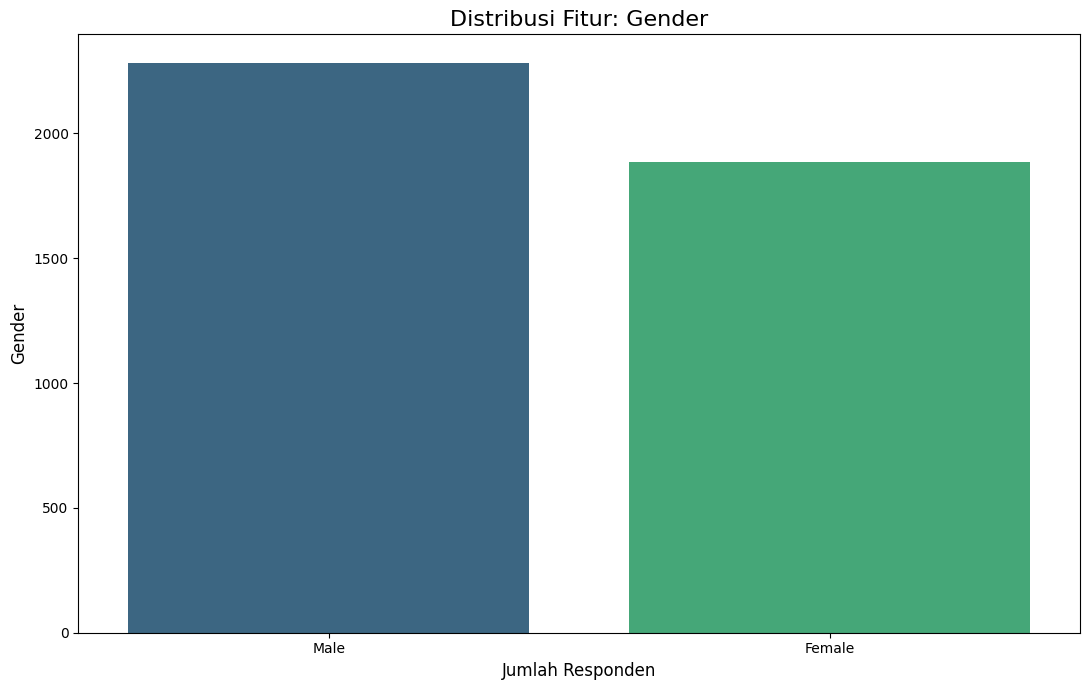

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


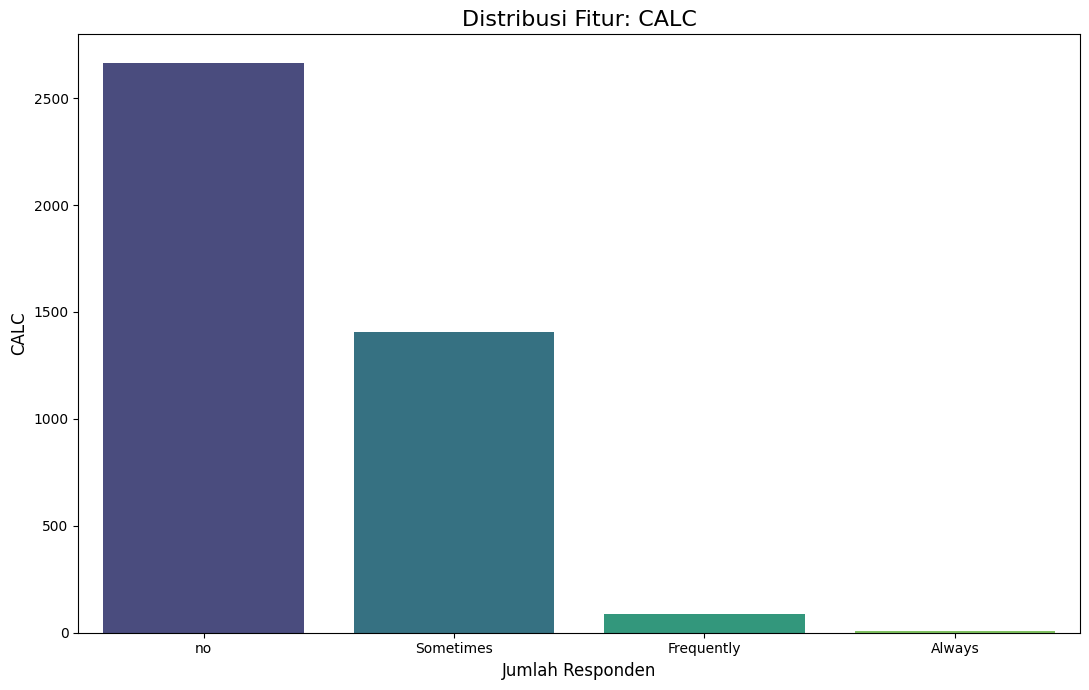

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


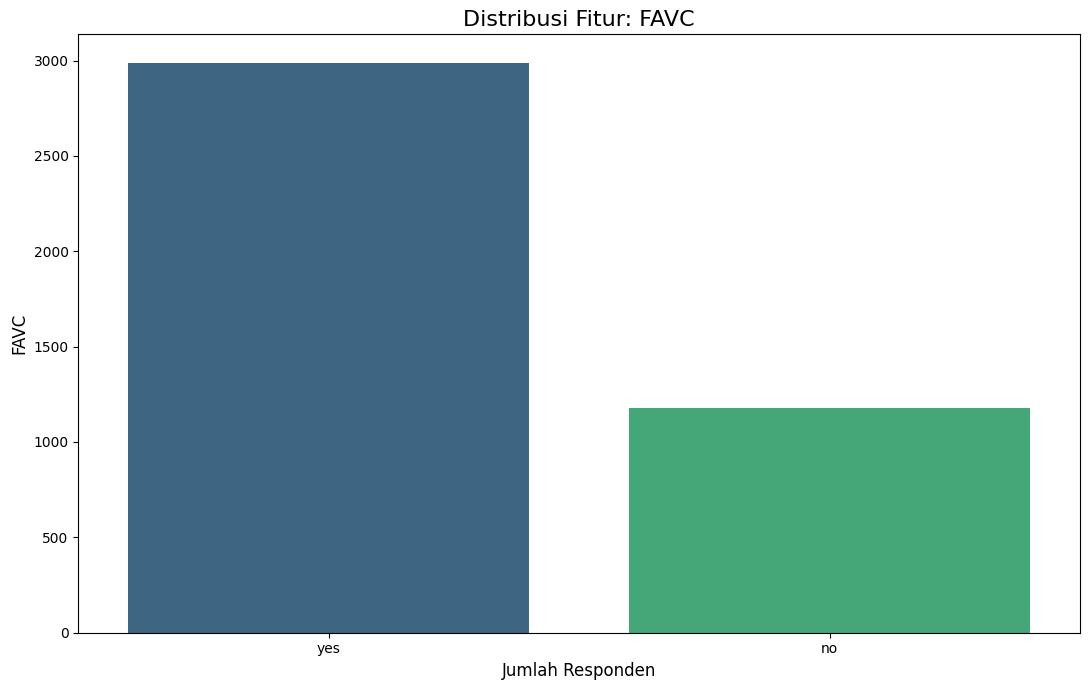

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


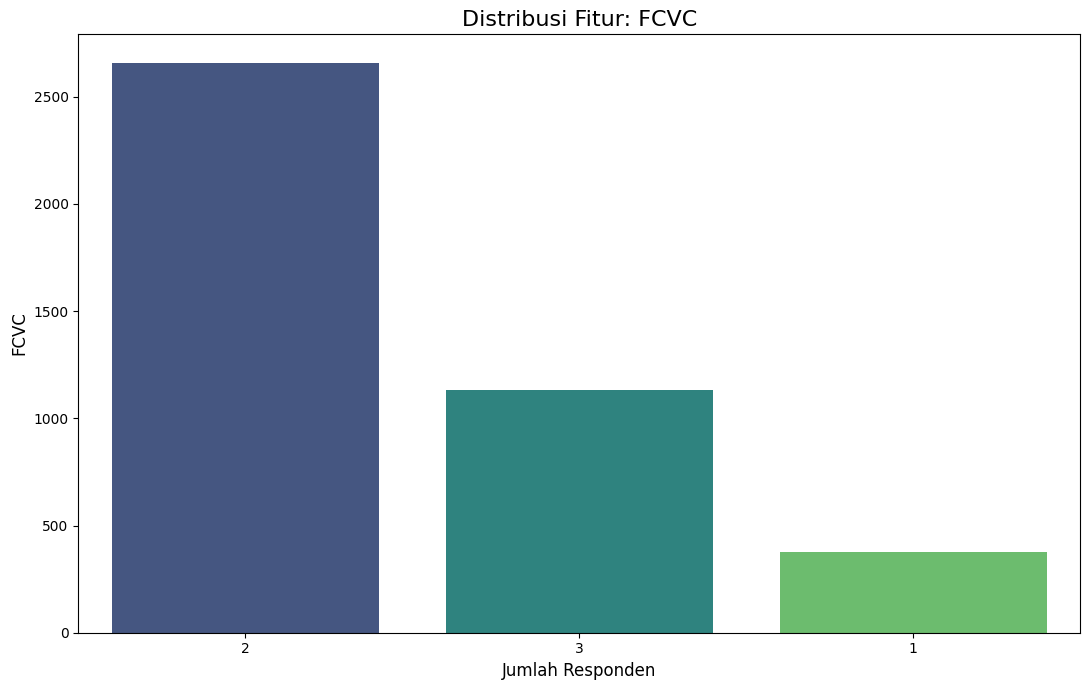

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


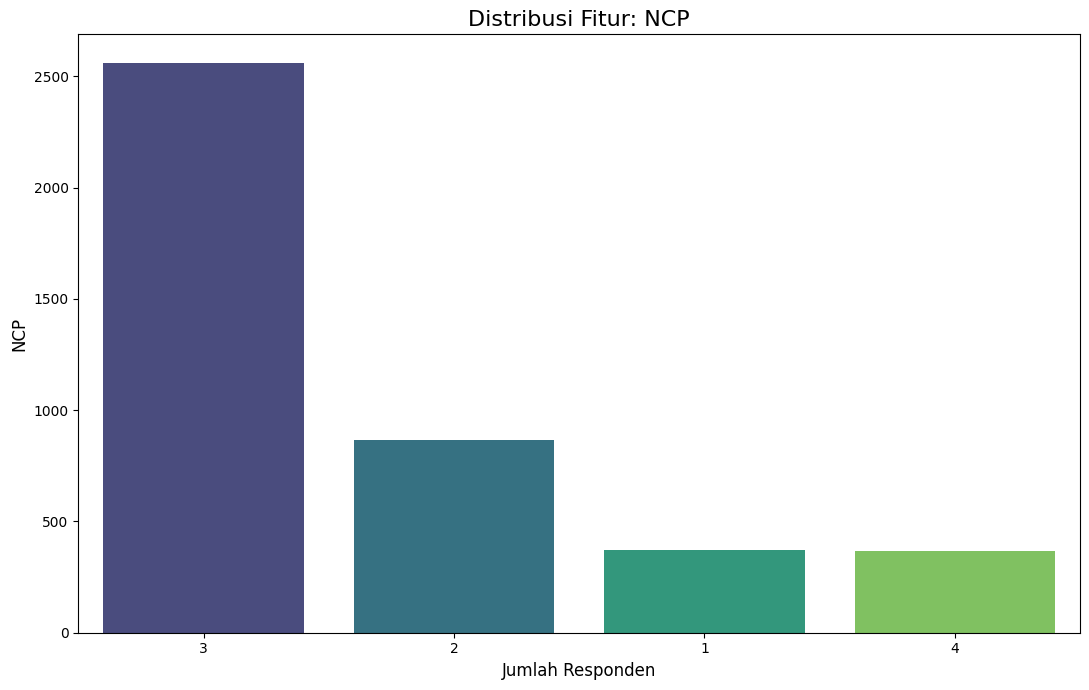

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


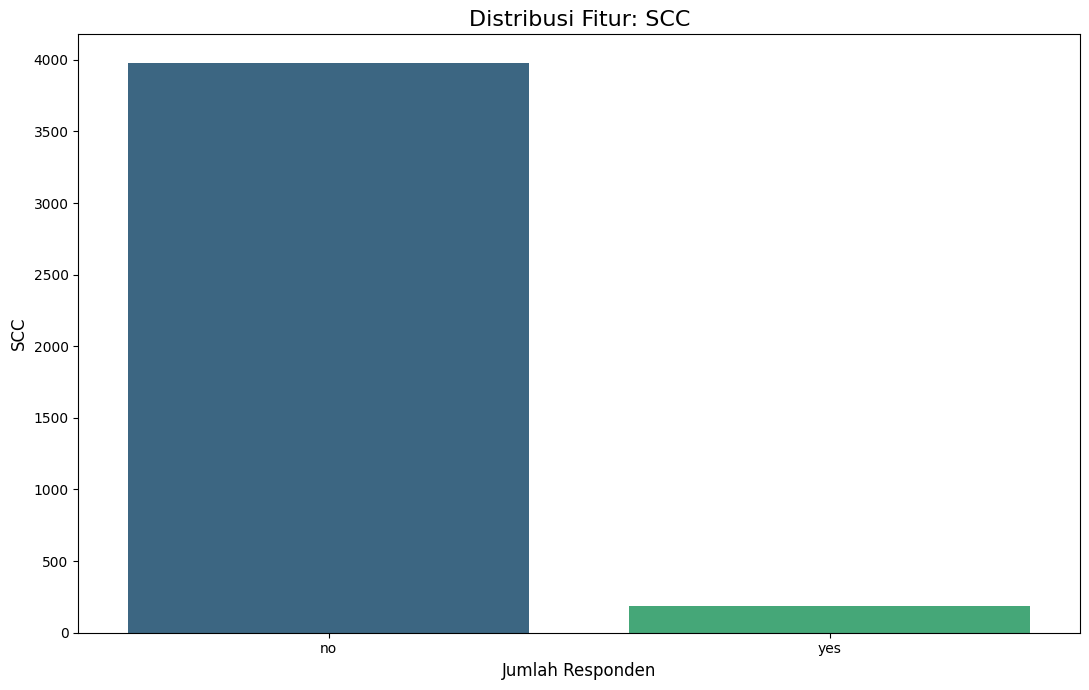

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


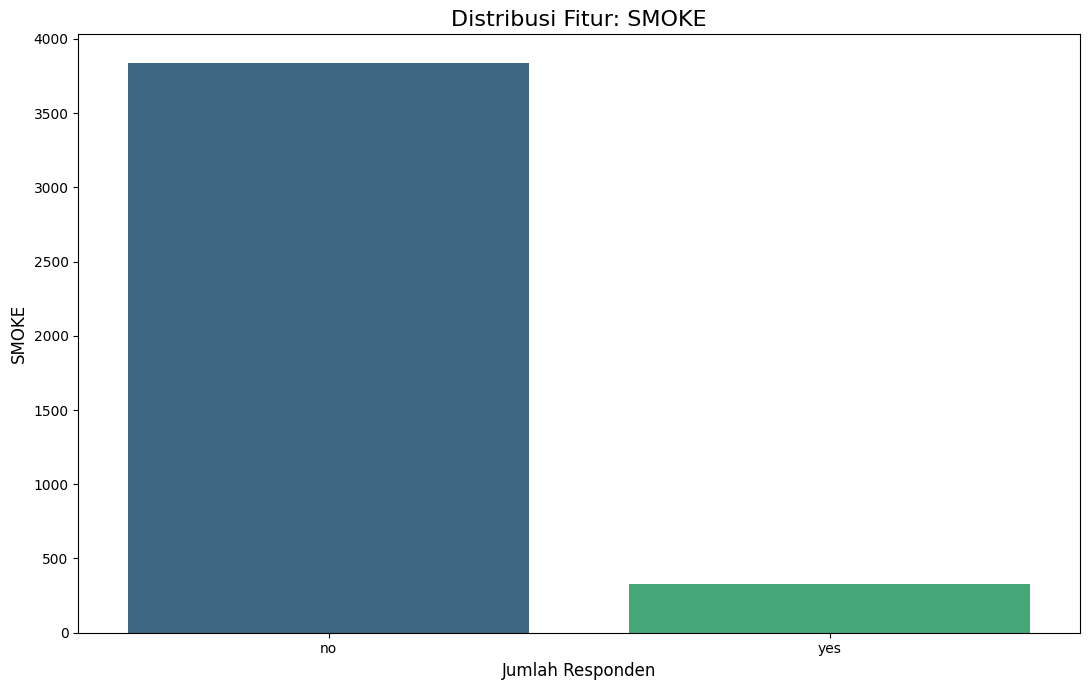

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


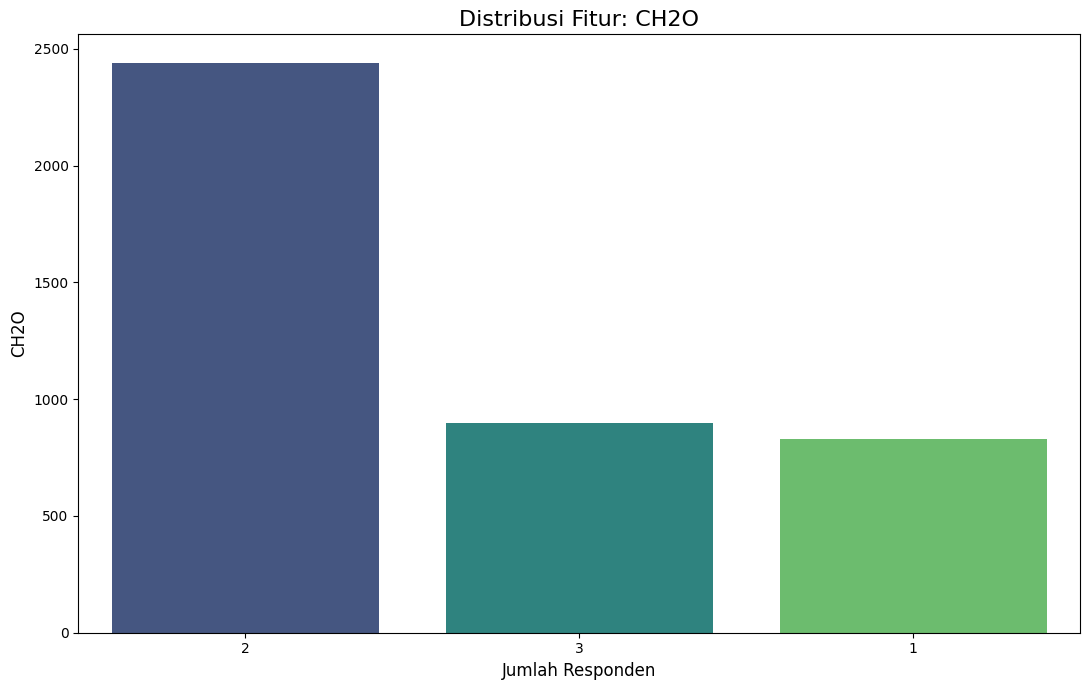

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


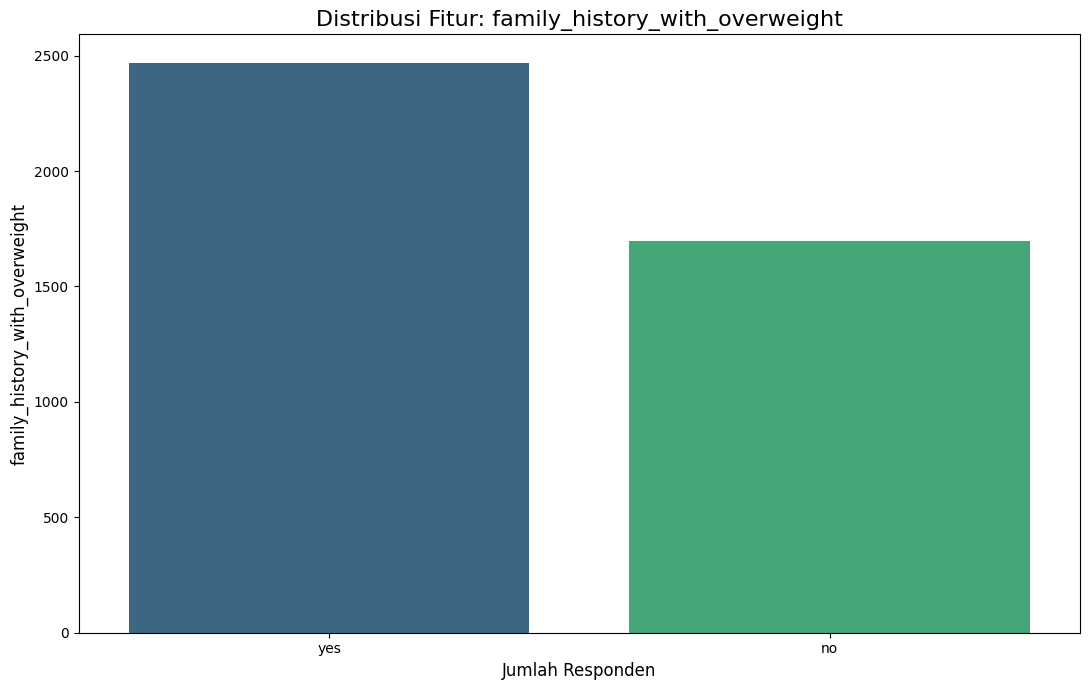

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


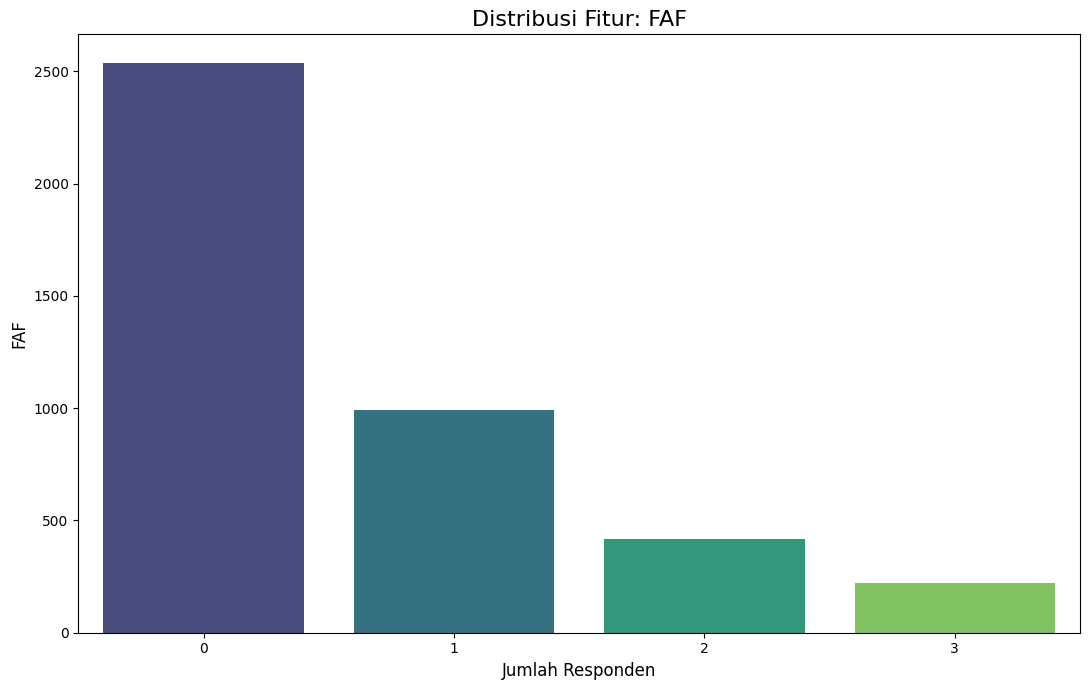

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


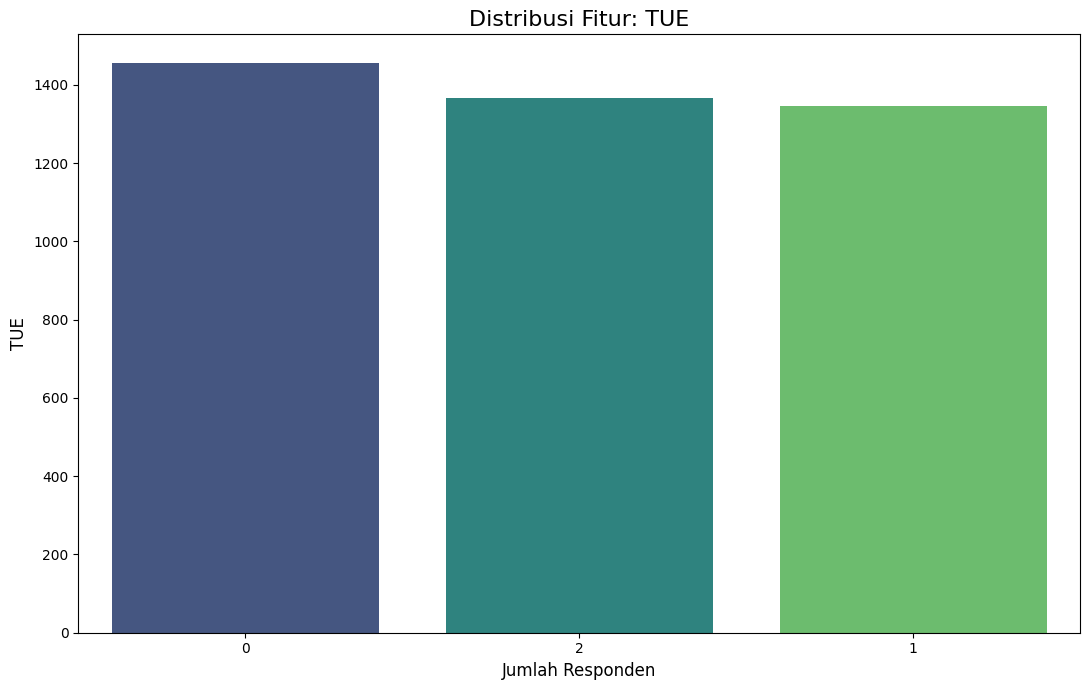

/tmp/ipython-input-1914069898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


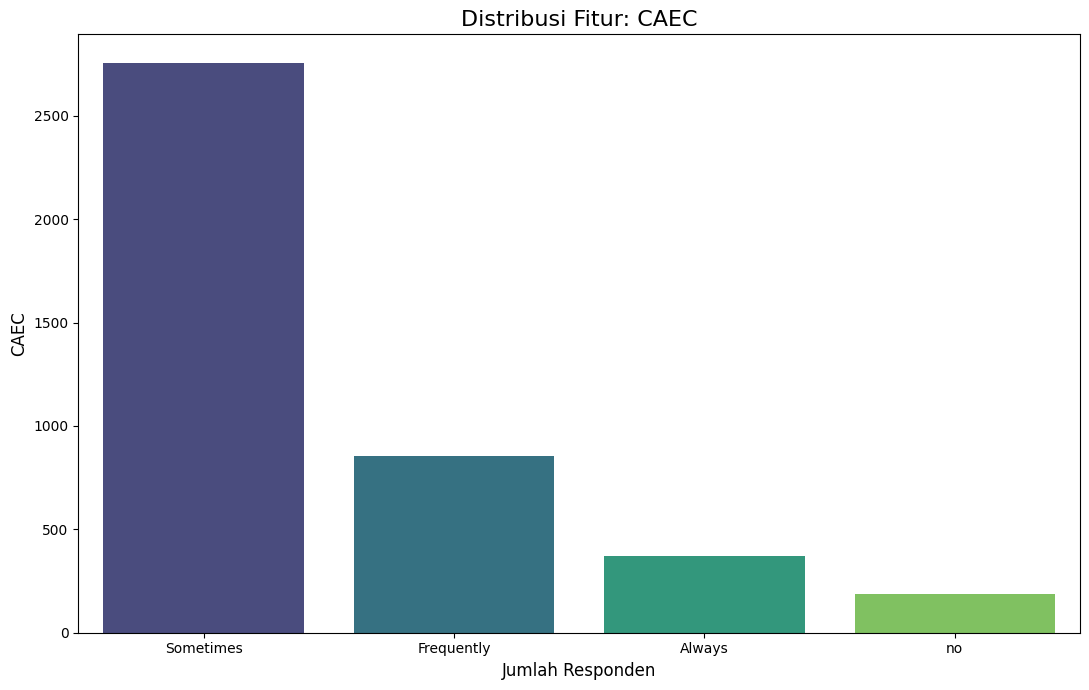

/tmp/ipython-input-1914069898.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


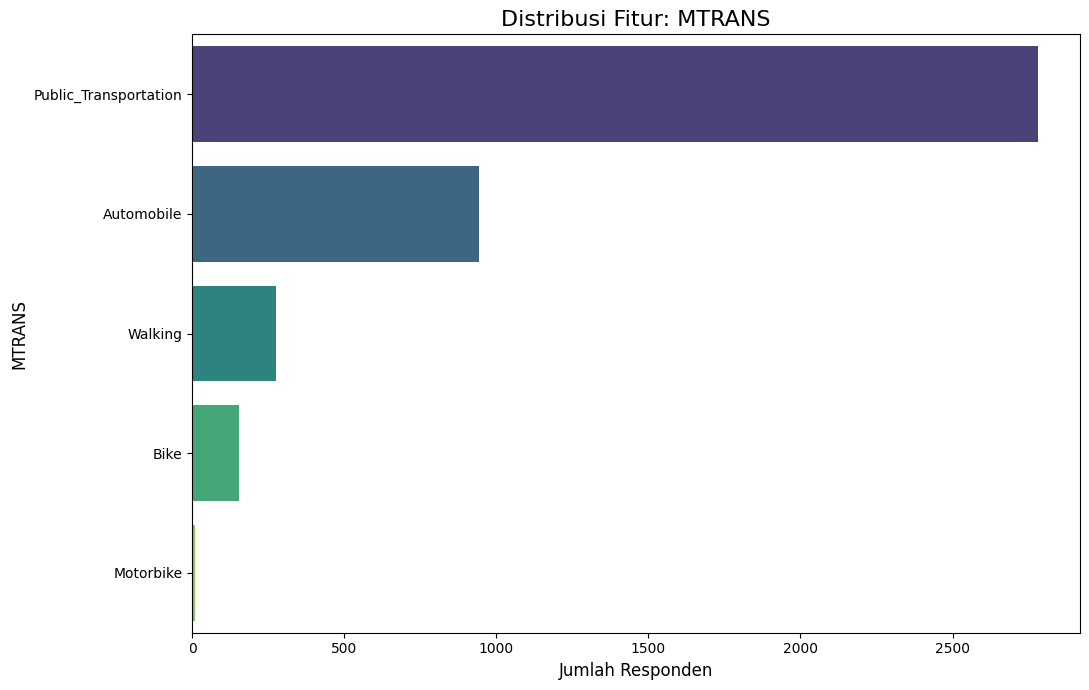

/tmp/ipython-input-1914069898.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)


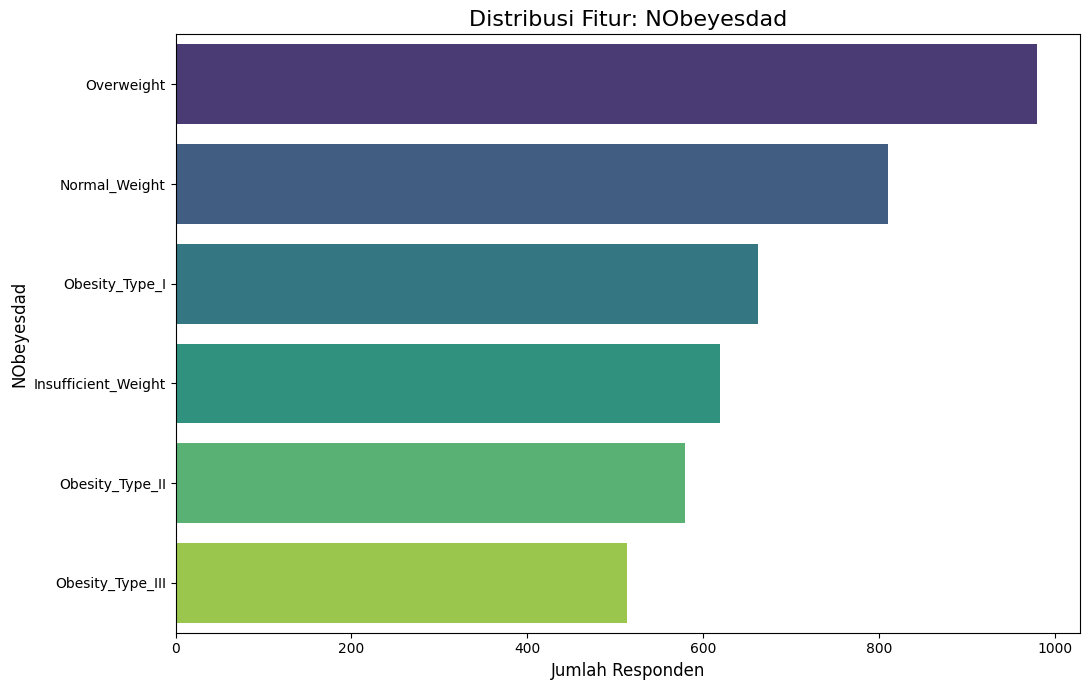

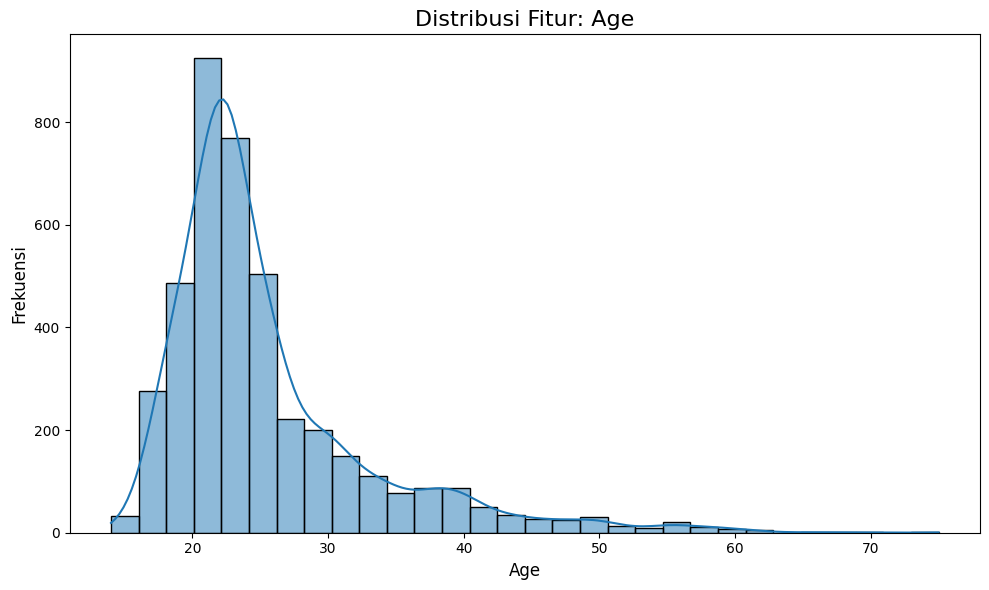

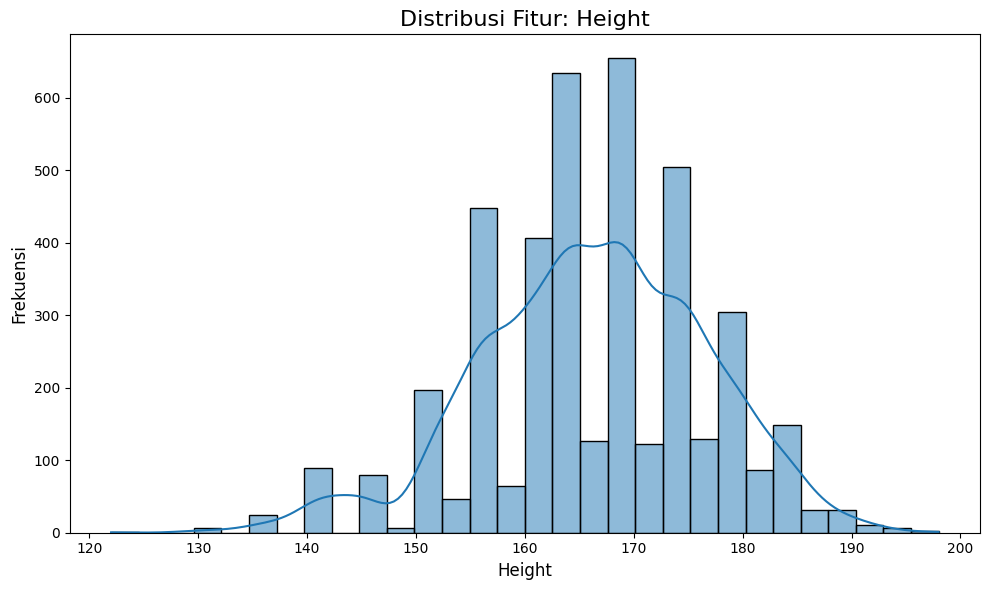

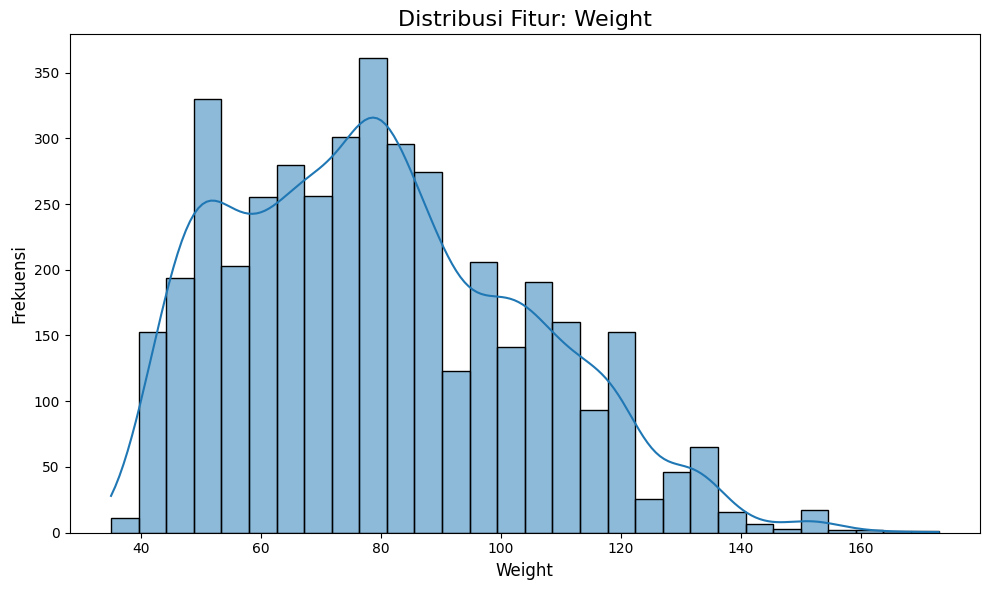

In [ ]:
def tampilkan_visualisasi_semua_fitur():

    categorical_feature = combined_df.select_dtypes(include=['object']).columns
    numerical_features = combined_df.select_dtypes(include=['number']).columns

    print("\nMemulai proses penampilan plot...")
    print("Tutup jendela plot yang muncul untuk melanjutkan ke plot berikutnya.")

    for feature in categorical_feature:
        plt.figure(figsize=(11, 7))
        if combined_df[feature].nunique() > 4:
            sns.countplot(y=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)
        else:
            sns.countplot(x=feature, data=combined_df, palette='viridis', order=combined_df[feature].value_counts().index)

        plt.title(f'Distribusi Fitur: {feature}', fontsize=16)
        plt.xlabel('Jumlah Responden', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.tight_layout()
        plt.show()

    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.histplot(combined_df[feature], kde=True, bins=30) # kde menambahkan garis kurva distribusi
        plt.title(f'Distribusi Fitur: {feature}', fontsize=16)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Frekuensi', fontsize=12)
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    tampilkan_visualisasi_semua_fitur()

## Split Dataset Into Training, Validation, Test

In [ ]:
# Split data into 80% training and 20% temporary (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

# Split temporary data into 50% validation and 50% test (which is 10% of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

X_train: (3333, 16)
X_val: (417, 16)
X_test: (417, 16)


## SMOTENC Oversampling

In [ ]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder # Corrected import


# Menampilkan distribusi kelas sebelum SMOTE pada data training
print("Distribusi kelas sebelum SMOTE (y_train):")
print(y_train.value_counts())

# Inisialisasi SMOTE
sm = SMOTENC(categorical_features = categorical_features, random_state=42)

# Terapkan SMOTE pada data training yang sudah di-encode dan original y_train
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Menampilkan distribusi kelas setelah SMOTE pada data training
print("\nDistribusi kelas setelah SMOTE (y_train_smote):\n", y_train_smote.value_counts())

# Assign X_train_smote and y_train_smote back to X_train and y_train for subsequent model training steps

Distribusi kelas sebelum SMOTE (y_train):
NObeyesdad
Overweight             784
Normal_Weight          649
Obesity_Type_I         530
Insufficient_Weight    495
Obesity_Type_II        464
Obesity_Type_III       411
Name: count, dtype: int64

Distribusi kelas setelah SMOTE (y_train_smote):
 NObeyesdad
Obesity_Type_III       784
Overweight             784
Normal_Weight          784
Insufficient_Weight    784
Obesity_Type_I         784
Obesity_Type_II        784
Name: count, dtype: int64


### Data Cleaning After Smote

In [ ]:
print("\n--- Mengecek Duplikasi dalam X_train_smote setelah SMOTE ---")

# Mengecek duplikasi di X_train_smote
duplicated_rows_smote = X_train_smote[X_train_smote.duplicated(keep=False)]

if not duplicated_rows_smote.empty:
    print(f"Ditemukan {len(duplicated_rows_smote)} baris duplikat dalam X_train_smote.")
    print("Berikut adalah beberapa contoh baris duplikat (termasuk duplikatnya):")
    display(duplicated_rows_smote.head())
else:
    print("Tidak ada baris duplikat yang ditemukan dalam X_train_smote setelah SMOTE.")



--- Mengecek Duplikasi dalam X_train_smote setelah SMOTE ---
Ditemukan 51 baris duplikat dalam X_train_smote.
Berikut adalah beberapa contoh baris duplikat (termasuk duplikatnya):


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS
146,25.653233,Female,165,109,Sometimes,yes,3,3,no,no,1,yes,0,0,Sometimes,Public_Transportation
513,24.000000,Male,165,116,no,yes,2,3,no,no,3,no,0,2,Frequently,Automobile
695,20.000000,Male,170,50,no,no,2,3,no,no,2,no,0,2,Sometimes,Public_Transportation
872,18.000000,Male,175,51,Sometimes,yes,2,3,no,no,1,no,1,1,Sometimes,Public_Transportation
884,26.000000,Female,159,110,Sometimes,yes,3,3,no,no,2,yes,0,0,Sometimes,Public_Transportation


In [ ]:
print("--- Menghapus Duplikasi dari X_train_smote dan y_train_smote ---")

initial_smote_rows = X_train_smote.shape[0]

# Gabungkan X_train_smote dan y_train_smote untuk mencari duplikasi secara keseluruhan
df_smote_combined = pd.concat([X_train_smote, y_train_smote], axis=1)

# Hapus duplikasi dan dapatkan indeks baris unik
df_smote_unique = df_smote_combined.drop_duplicates()

# Pisahkan kembali ke X_train_smote dan y_train_smote yang bersih
X_train_smote = df_smote_unique.drop(columns=['NObeyesdad'])
y_train_smote = df_smote_unique['NObeyesdad']

final_smote_rows = X_train_smote.shape[0]
dropped_rows_count = initial_smote_rows - final_smote_rows

print(f"Jumlah baris sebelum penghapusan duplikasi: {initial_smote_rows}")
print(f"Jumlah baris setelah penghapusan duplikasi: {final_smote_rows}")
print(f"Jumlah baris duplikat yang dihapus: {dropped_rows_count}")

print("\n--- Cek Ulang Duplikasi dalam X_train_smote setelah penghapusan ---")
# Mengecek ulang duplikasi di X_train_smote
duplicated_rows_smote_after_drop = X_train_smote[X_train_smote.duplicated(keep=False)]

if not duplicated_rows_smote_after_drop.empty:
    print(f"❌ Masih ditemukan {len(duplicated_rows_smote_after_drop)} baris duplikat setelah penghapusan. Ini tidak diharapkan.")
else:
    print("✅ Tidak ada baris duplikat yang ditemukan dalam X_train_smote setelah penghapusan.")


--- Menghapus Duplikasi dari X_train_smote dan y_train_smote ---
Jumlah baris sebelum penghapusan duplikasi: 4704
Jumlah baris setelah penghapusan duplikasi: 4678
Jumlah baris duplikat yang dihapus: 26

--- Cek Ulang Duplikasi dalam X_train_smote setelah penghapusan ---
✅ Tidak ada baris duplikat yang ditemukan dalam X_train_smote setelah penghapusan.


In [ ]:
print("\nDistribusi kelas setelah SMOTE (y_train_smote):\n", y_train_smote.value_counts())


Distribusi kelas setelah SMOTE (y_train_smote):
 NObeyesdad
Overweight             784
Normal_Weight          783
Obesity_Type_II        783
Obesity_Type_I         781
Obesity_Type_III       774
Insufficient_Weight    773
Name: count, dtype: int64


## Inisiate CatBoost Model

In [ ]:
#CatBoost_Model = CatBoostClassifier(
#    iterations=1000,
#    learning_rate=0.03,
#    depth=4,
#    early_stopping_rounds=100,
#    cat_features=categorical_features,
#    loss_function='MultiClass',
#    eval_metric='Accuracy',
#    l2_leaf_reg =5,
#    random_state=42,
#    verbose=0
#)


#CatBoost_Model = CatBoostClassifier(
#    iterations=1500,
#    learning_rate=0.03,
#    depth=4,
#    cat_features=categorical_features,
#    loss_function='MultiClass',
#    eval_metric='Accuracy',
#    l2_leaf_reg=5,
#    random_state=42,
#    verbose=0
#)

In [ ]:
CatBoost_Model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=4,
    early_stopping_rounds=50,
    cat_features=categorical_features,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    l2_leaf_reg=3,
    random_state=42
)

## Training the CatBoost Model

### Validation Data

In [ ]:
# Sebelum Combined Data

#----- Tanpa Early Stopping ------
#Percobaan 1. CatBoost Model: learning rate = 0.05, iterasi = 1000 : BestTest = 0.07, BestLearn = 0.02, Iterasi = 998
#Percobaan 2. CatBoost Model: learning rate = 0.05, iterasi = 1500 : BestTest = 0.05, BestLearn = 0.01, Iterasi = 1499

#----- Dengan Early Stopping ------
#---Ubah Depth---
#Percobaan 1. Learning Rate = 0.05, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.95, BestIterasi = 267, BestLearn = 1.00 Best
#Percobaan 2. Learning Rate = 0.05, Depth = 10, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.94, BestIterasi = 205, BestLearn = 1.00
#Percobaan 2. Learning Rate = 0.05, Depth = 6, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.93, BestIterasi = 68, BestLearn = 1.00
#---Ubah Learning Rate---
#Percobaan 1. Learning Rate = 0.04, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.95, BestIterasi = 269, BestLearn = 0.99
#Percobaan 2. Learning Rate = 0.03, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.92, BestIterasi = 161, BestLearn = 0.97

In [ ]:
# Setelah Combined Data

#----- Dengan Early Stopping ------
#---Ubah Depth---
#Percobaan 1. Learning Rate = 0.05, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.9552, BestIterasi = 275, BestLearn = 0.9935, Waktu = 90 Detik
#Percobaan 2. Learning Rate = 0.05, Depth = 10, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.9410, BestIterasi = 112, BestLearn = 0.9817, Waktu = 127 Detik
#Percobaan 2. Learning Rate = 0.05, Depth = 6, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.9623, BestIterasi = 384, BestLearn = 0.9882, Waktu = 59 Detik
#---Ubah Learning Rate---
#Percobaan 1. Learning Rate = 0.04, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.9245, BestIterasi = 108, BestLearn = 0.9614, Waktu = 39 Detik
#Percobaan 2. Learning Rate = 0.03, Depth = 8, Iterasi = 1000, Early_Stopping = 50 : BestTest = 0.9316, BestIterasi = 94, BestLearn = 0.9523, Waktu = 36 Detik

0:	learn: 0.5865755	test: 0.5155875	best: 0.5155875 (0)	total: 195ms	remaining: 4m 51s
200:	learn: 0.9247542	test: 0.9208633	best: 0.9232614 (199)	total: 22.5s	remaining: 2m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9352517986
bestIteration = 293

Shrink model to first 294 iterations.

=== HASIL TRAINING CATBOOST ===
Waktu Training: 33.90 detik
Iterasi Terbaik: 293
Training Accuracy: 0.9545
Validation Accuracy: 0.9353
Contoh 5 nilai training loss pertama: [1.7371518789208038, 1.6827720271345925, 1.6397987924208284, 1.5947133955213253, 1.5563678818117894]
Contoh 5 nilai validation loss pertama: [1.7405109745364091, 1.6881362564542841, 1.6485065462631612, 1.6052915730971355, 1.568368173645738]


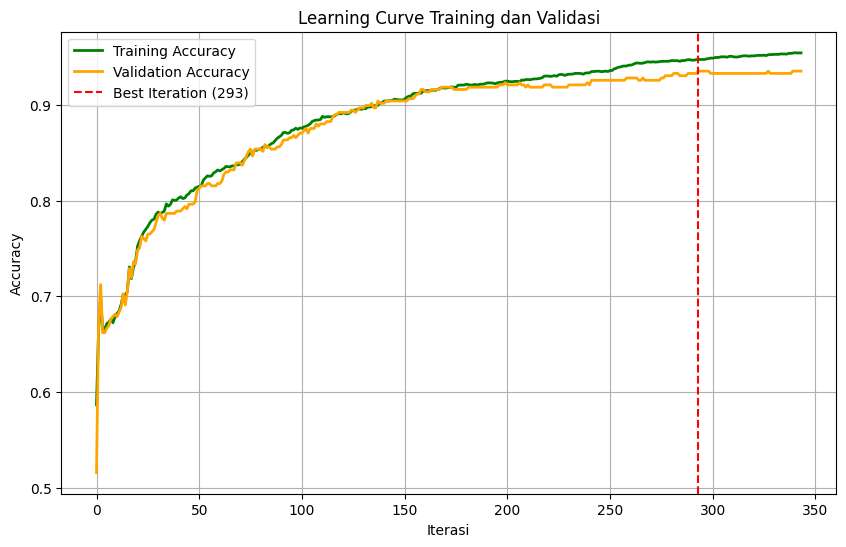

In [ ]:
start_time = time.time()

# Latih model dengan evaluasi & early stopping
# X_train_smote (which is now X_train) contains numerical categorical features.
CatBoost_Model.fit(
    X_train_smote, y_train_smote,
    cat_features=categorical_features, # Use indices for numerical categorical features
    eval_set=(X_val, y_val),
    use_best_model=True,
    verbose=200
)

train_time = time.time() - start_time

# Ambil hasil evaluasi
eval_history = CatBoost_Model.get_evals_result()
best_iter = CatBoost_Model.get_best_iteration()

# Coba deteksi nama metrik yang tersedia
best_scores = CatBoost_Model.get_best_score()

# Ambil metrik yang ada (Accuracy atau MultiClass)
val_metrics = list(best_scores['validation'].keys())
metric_name = val_metrics[0]

best_score_val = best_scores['validation'][metric_name]
best_score_train = best_scores['learn'][metric_name]

# ------------------------------
# Tampilkan hasil ringkasan
print("\n=== HASIL TRAINING CATBOOST ===")
print(f"Waktu Training: {train_time:.2f} detik")
print(f"Iterasi Terbaik: {best_iter}")
print(f"Training {metric_name}: {best_score_train:.4f}")
print(f"Validation {metric_name}: {best_score_val:.4f}")

training_loss = eval_history['learn']['MultiClass'] # Ganti 'MultiClass' dengan nama loss function yang tepat jika berbeda

# Mengakses riwayat loss untuk validation set
validation_loss = eval_history['validation']['MultiClass'] # Ganti 'MultiClass' dengan nama loss function yang tepat jika berbeda

print("Contoh 5 nilai training loss pertama:", training_loss[:5])
print("Contoh 5 nilai validation loss pertama:", validation_loss[:5])

# ------------------------------
# Visualisasi metrik training vs validasi
plt.figure(figsize=(10, 6))
plt.plot(eval_history['learn'][metric_name], label=f'Training {metric_name}', color='green', linewidth=2)
plt.plot(eval_history['validation'][metric_name], label=f'Validation {metric_name}', color='orange', linewidth=2)
plt.axvline(best_iter, color='red', linestyle='--', label=f'Best Iteration ({best_iter})')
plt.xlabel('Iterasi')
plt.ylabel(metric_name)
plt.title(f'Learning Curve Training dan Validasi')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#CatBoost_Model.fit(X_train, y_train, use_best_model=True)
y_pred = CatBoost_Model.predict(X_val)
print("\n===== HASIL EVALUASI MODEL CatBoost =====")
accuracy = accuracy_score(y_val, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\n")

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("============================================")


===== HASIL EVALUASI MODEL CatBoost =====
Akurasi Model: 93.53%


Confusion Matrix:
[[62  0  0  0  0  0]
 [ 8 66  0  0  0  7]
 [ 0  0 62  1  1  2]
 [ 0  0  0 56  2  0]
 [ 0  0  0  2 50  0]
 [ 0  2  2  0  0 94]]


Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      1.00      0.94        62
      Normal_Weight       0.97      0.81      0.89        81
     Obesity_Type_I       0.97      0.94      0.95        66
    Obesity_Type_II       0.95      0.97      0.96        58
   Obesity_Type_III       0.94      0.96      0.95        52
         Overweight       0.91      0.96      0.94        98

           accuracy                           0.94       417
          macro avg       0.94      0.94      0.94       417
       weighted avg       0.94      0.94      0.93       417



/tmp/ipython-input-139270757.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


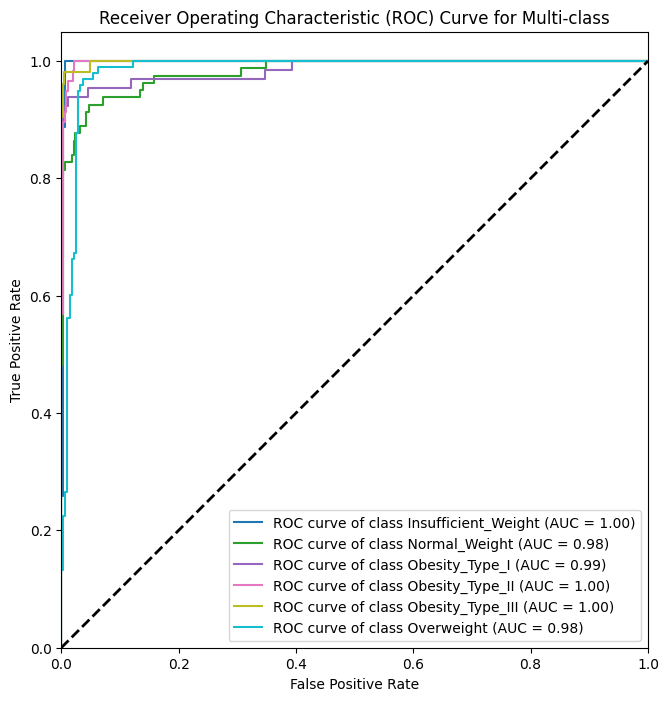


AUC for each class:
  Insufficient_Weight: 1.00
  Normal_Weight: 0.98
  Obesity_Type_I: 0.99
  Obesity_Type_II: 1.00
  Obesity_Type_III: 1.00
  Overweight: 0.98


In [ ]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get all unique classes from the training data to ensure all classes are included
all_classes = sorted(y_train.unique())

# Binarize the output
y_val_binarized = label_binarize(y_val, classes=all_classes)
n_classes = y_val_binarized.shape[1]

# Get the predicted probabilities for each class
# FIX: Use predict_proba instead of fit to get predicted probabilities
y_prob = CatBoost_Model.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Use RocCurveDisplay for plotting and getting results
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    # Use RocCurveDisplay.from_predictions to plot and get results for each class
    roc_display = RocCurveDisplay.from_predictions(y_val_binarized[:, i], y_prob[:, i], name=f'ROC curve of class {all_classes[i]}', ax=ax, color=colors(i))
    fpr[i] = roc_display.fpr
    tpr[i] = roc_display.tpr
    roc_auc[i] = roc_display.roc_auc


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

print("\nAUC for each class:")
for i in range(n_classes):
    print(f"  {all_classes[i]}: {roc_auc[i]:.2f}")

### Test Data

In [ ]:
# Predict on the test set
y_pred_test = CatBoost_Model.predict(X_test)

print("===== HASIL EVALUASI MODEL CatBoost PADA DATA TESTING =====")
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Akurasi Model pada Test Set: {accuracy_test * 100:.2f}%")
print("\n")
print("Confusion Matrix pada Test Set:")
print(confusion_matrix(y_test, y_pred_test))
print("\n")
print("Classification Report pada Test Set:")
print(classification_report(y_test, y_pred_test))
print("==========================================================")

===== HASIL EVALUASI MODEL CatBoost PADA DATA TESTING =====
Akurasi Model pada Test Set: 88.73%


Confusion Matrix pada Test Set:
[[58  4  0  0  0  0]
 [10 62  0  0  0  9]
 [ 0  0 63  2  0  2]
 [ 0  0  3 51  4  0]
 [ 0  0  0  1 50  0]
 [ 0  8  4  0  0 86]]


Classification Report pada Test Set:
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.94      0.89        62
      Normal_Weight       0.84      0.77      0.80        81
     Obesity_Type_I       0.90      0.94      0.92        67
    Obesity_Type_II       0.94      0.88      0.91        58
   Obesity_Type_III       0.93      0.98      0.95        51
         Overweight       0.89      0.88      0.88        98

           accuracy                           0.89       417
          macro avg       0.89      0.90      0.89       417
       weighted avg       0.89      0.89      0.89       417



/tmp/ipython-input-820912494.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


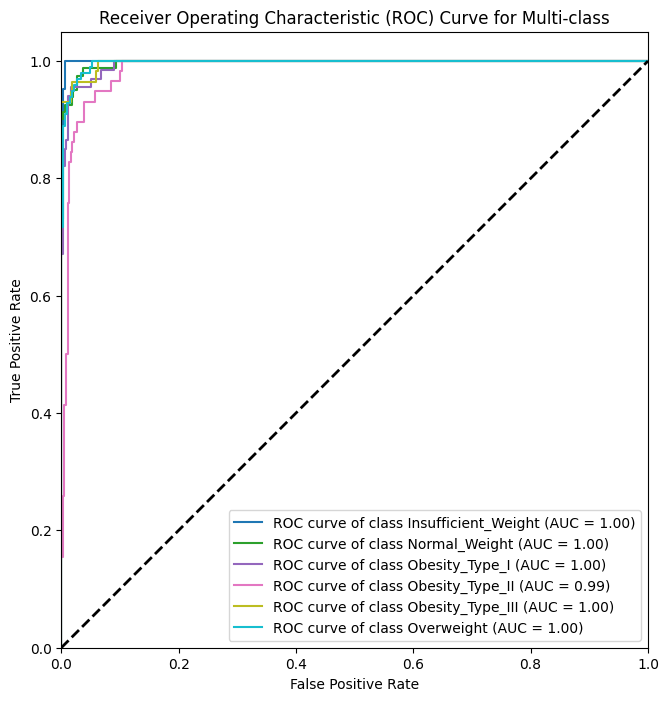


AUC for each class:
  Insufficient_Weight: 1.00
  Normal_Weight: 1.00
  Obesity_Type_I: 1.00
  Obesity_Type_II: 0.99
  Obesity_Type_III: 1.00
  Overweight: 1.00


In [ ]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get all unique classes from the training data to ensure all classes are included
all_classes = sorted(y_train.unique())

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=all_classes)
n_classes = y_test_binarized.shape[1]

# Get the predicted probabilities for each class
# FIX: Use predict_proba instead of fit to get predicted probabilities
y_prob = CatBoost_Model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Use RocCurveDisplay for plotting and getting results
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    # Use RocCurveDisplay.from_predictions to plot and get results for each class
    roc_display = RocCurveDisplay.from_predictions(y_test_binarized[:, i], y_prob[:, i], name=f'ROC curve of class {all_classes[i]}', ax=ax, color=colors(i))
    fpr[i] = roc_display.fpr
    tpr[i] = roc_display.tpr
    roc_auc[i] = roc_display.roc_auc


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()

print("\nAUC for each class:")
for i in range(n_classes):
    print(f"  {all_classes[i]}: {roc_auc[i]:.2f}")

# Testing Model

## Input Data

In [ ]:
def get_user_input():
    """Fungsi untuk mengambil input dari pengguna dengan validasi dan pilihan angka untuk kategorikal."""
    print("\nSilakan masukkan data untuk prediksi tingkat obesitas:")
    data = {}
    try:
        # Gender
        gender_choice = int(input("Jenis Kelamin (0: Female, 1: Male): "))
        data['Gender'] = 'Female' if gender_choice == 0 else 'Male'

        # Age
        data['Age'] = int(input("Umur: "))

        # Height
        data['Height'] = int(input("Tinggi Badan (cm): "))

        # Weight
        data['Weight'] = int(input("Berat Badan (kg): "))

        # family_history_with_overweight
        family_history_choice = int(input("Riwayat keluarga dengan berat badan berlebih? (0: Tidak ada, 1: Ada): "))
        data['family_history_with_overweight'] = 'no' if family_history_choice == 0 else 'yes'

        # FAVC
        favc_choice = int(input("Sering makan makanan tinggi kalori dalam seminggu ? (0: Tidak Pernah, 1: Sering (2-3 seminggu)): "))
        data['FAVC'] = 'no' if favc_choice == 0 else 'yes'

        # FCVC
        data['FCVC'] = int(input("Frekuensi makan sayur (1: Tidak Pernah, 2: Kadang-kadang, 3: Setiap Makan): "))

        # NCP
        data['NCP'] = int(input("Berapa kali makan utama per hari? (1-4): "))

        # CAEC
        caec_choice = int(input("Dalam 7 hari terakhir, berapa hari anda makan cemilan di luar waktu makan utama? (0: 6-7 hari, 1: 3-5 hari, 2: 1-2 hari, 3: Tidak Pernah): "))
        # FIX: Change 'No' to 'no' to match potential casing in original data
        caec_map = {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'}
        data['CAEC'] = caec_map.get(caec_choice, 'no') # Default ke 'no' jika input tidak valid

        # SMOKE
        smoke_choice = int(input("Apakah Anda merokok? (0: no, 1: yes): "))
        data['SMOKE'] = 'no' if smoke_choice == 0 else 'yes'

        # CH2O
        data['CH2O'] = int(input("Berapa banyak air yang diminum setiap hari? (1: <1L, 2: 1-2L, 3: >2L): "))

        # SCC
        scc_choice = int(input("Memantau kalori yang Anda makan? (0: no, 1: yes): "))
        data['SCC'] = 'no' if scc_choice == 0 else 'yes'

        # FAF
        data['FAF'] = int(input("Berapa menit anda melakukan aktivitas fisik (jalan, bersepeda, olahraga ringan) (0: < 15 menit, 1: 15-30 menit, 2: 30-60 menit, 3: > 60 menit): "))

        # TUE
        data['TUE'] = int(input("Waktu penggunaan perangkat teknologi (0: <1 jam, 1: 1-2 jam, 2: >2 jam): "))

        # CALC
        calc_choice = int(input("Seberapa sering minum alkohol? (0: Always, 1: Frequently, 2: Sometimes, 3: No): "))
        # FIX: Change 'No' to 'no' to match potential casing in original data
        calc_map = {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'}
        data['CALC'] = calc_map.get(calc_choice, 'no') # Default ke 'no' jika input tidak valid

        # MTRANS
        mtrans_choice = int(input("Transportasi yang biasa digunakan (0: Automobile, 1: Bike, 2: Motorbike, 3: Public_Transportation, 4: Walking): "))
        mtrans_map = {0: 'Automobile', 1: 'Bike', 2: 'Motorbike', 3: 'Public_Transportation', 4: 'Walking'}
        data['MTRANS'] = mtrans_map.get(mtrans_choice, 'Public_Transportation') # Default jika input tidak valid


        return pd.DataFrame([data])
    except ValueError:
        print("❌ Input tidak valid. Mohon masukkan data dalam format angka yang benar sesuai pilihan.")
        return None
    except KeyError:
        print("❌ Input pilihan tidak valid. Mohon masukkan angka pilihan yang tersedia.")
        return None


# Ambil input dari pengguna
data_pasien_baru = get_user_input()


Silakan masukkan data untuk prediksi tingkat obesitas:
Jenis Kelamin (0: Female, 1: Male): 1
Umur: 22
Tinggi Badan (cm): 168
Berat Badan (kg): 73
Riwayat keluarga dengan berat badan berlebih? (0: Tidak ada, 1: Ada): 0
Sering makan makanan tinggi kalori dalam seminggu ? (0: Tidak Pernah, 1: Sering (2-3 seminggu)): 1
Frekuensi makan sayur (1: Tidak Pernah, 2: Kadang-kadang, 3: Setiap Makan): 3
Berapa kali makan utama per hari? (1-4): 3
Dalam 7 hari terakhir, berapa hari anda makan cemilan di luar waktu makan utama? (0: 6-7 hari, 1: 3-5 hari, 2: 1-2 hari, 3: Tidak Pernah): 3
Apakah Anda merokok? (0: no, 1: yes): 0
Berapa banyak air yang diminum setiap hari? (1: <1L, 2: 1-2L, 3: >2L): 2
Memantau kalori yang Anda makan? (0: no, 1: yes): 0
Berapa menit anda melakukan aktivitas fisik (jalan, bersepeda, olahraga ringan) (0: < 15 menit, 1: 15-30 menit, 2: 30-60 menit, 3: > 60 menit): 0
Waktu penggunaan perangkat teknologi (0: <1 jam, 1: 1-2 jam, 2: >2 jam): 2
Seberapa sering minum alkohol? (0:

In [ ]:
print(data_pasien_baru)

  Gender  Age  Height  Weight family_history_with_overweight FAVC  FCVC  NCP  \
0   Male   22     168      73                             no  yes     3    3   

  CAEC SMOKE  CH2O SCC  FAF  TUE CALC     MTRANS  
0   no    no     2  no    0    2   no  Motorbike  


##LIME Analisis Faktor Dominan

### Inisiasi LIME

In [ ]:
# Recreate X_transformed from the original df to ensure categorical columns are strings
X_transformed_for_encoding = df.drop('NObeyesdad', axis=1).copy()

# Salin data fitur dan siapkan dictionary untuk menyimpan LabelEncoders
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    # Fit the encoder on the original string data
    le.fit(X_transformed_for_encoding[col])
    label_encoders[col] = le

# Transform X_train menggunakan encoders yang sudah dilatih
X_train_encoded = X_train.copy()
for col, encoder in label_encoders.items():
    # Ensure the column exists and is not all NaN in X_train before attempting transform
    if col in X_train_encoded.columns and not X_train_encoded[col].isnull().all():
         X_train_encoded[col] = encoder.transform(X_train_encoded[col])
    else:
        # Handle cases where a column might be missing or all NaN in X_train (shouldn't happen with train_test_split)
        print(f"Warning: Column '{col}' not found or is all NaN in X_train_encoded. Skipping encoding.")


# Latih CatBoost_Model pada data yang sudah sepenuhnya numerik
# Ensure CatBoost_Model is defined - assuming it's defined in a previous cell
if 'CatBoost_Model' in locals():
    print("Training CatBoost Model on encoded training data...")
    CatBoost_Model.fit(X_train_encoded, y_train, cat_features=categorical_features, verbose=0) # verbose=0 to avoid printing training steps again
    print("Training complete.")
else:
    print("Error: CatBoost_Model is not defined. Please run the cell that initializes CatBoost_Model first.")


categorical_names = {}
# Use columns from X_train_encoded to get numerical indices
for col in categorical_features:
    if col in X_train_encoded.columns:
        col_idx = X_train_encoded.columns.get_loc(col)
        categorical_names[col_idx] = label_encoders[col].classes_.tolist()


# Ensure explainer is created only if CatBoost_Model is trained
if 'CatBoost_Model' in locals():
    try:
        # Inisialisasi explainer LIME dengan random_state
        explainer = LimeTabularExplainer(
            training_data=X_train_encoded.values,
            feature_names=X_train_encoded.columns.tolist(),
            class_names=CatBoost_Model.classes_,
            categorical_features=[X_train_encoded.columns.get_loc(col) for col in categorical_features if col in X_train_encoded.columns], # Use indices from encoded data
            categorical_names= categorical_names,
            mode='classification',
            random_state=42 # Menetapkan random state di sini
        )
        print("Persiapan untuk LIME selesai. Model telah dilatih pada data numerik dan explainer siap.")
    except Exception as e:
        print(f"Error creating LIME explainer: {e}")
else:
     print("LIME explainer could not be created because CatBoost_Model is not defined.")

Training CatBoost Model on encoded training data...
Training complete.
Persiapan untuk LIME selesai. Model telah dilatih pada data numerik dan explainer siap.


### Tampilkan LIME

Hasil Prediksi: Berat Badan Normal

=== Probabilitas Konsisten (Input String Asli) ===
- Berat Badan Normal: 56.81%
- Kelebihan Berat Badan: 42.57%
- Obesitas Tingkat I: 0.55%
- Obesitas Tingkat II: 0.05%
- Kekurangan Berat Badan: 0.02%
- Obesitas Tingkat III: 0.00%

🔍 Menganalisis Faktor Dominan dengan LIME...

✅ Faktor Pendukung Prediksi:
- 60.00 < Weight <= 78.00 (Bobot Pengaruh: 0.35250)
- 166.00 < Height <= 174.00 (Bobot Pengaruh: 0.03447)
- 21.00 < Age <= 23.00 (Bobot Pengaruh: 0.02527)
- NCP=3 (Bobot Pengaruh: 0.02184)
- CH2O=2 (Bobot Pengaruh: 0.01308)
- FCVC=3 (Bobot Pengaruh: 0.01291)
- family_history_with_overweight=no (Bobot Pengaruh: 0.01049)
- SMOKE=no (Bobot Pengaruh: 0.00606)
- TUE=2 (Bobot Pengaruh: 0.00604)

❌ Faktor Bertentangan dengan Prediksi:
- MTRANS=Motorbike (Bobot Pengaruh: -0.08928)
- SCC=no (Bobot Pengaruh: -0.01176)
- FAVC=yes (Bobot Pengaruh: -0.01155)
- CAEC=no (Bobot Pengaruh: -0.00797)
- CALC=no (Bobot Pengaruh: -0.00664)
- FAF=0 (Bobot Pengaruh: -0.001

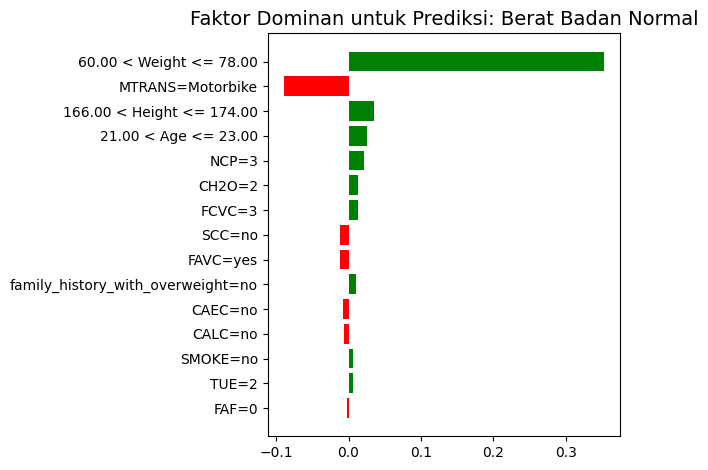

In [ ]:
# 2. Siapkan Data untuk Prediksi dan LIME (Encode Input Pasien)
pasien_encoded_df = data_pasien_baru.copy()
for col, encoder in label_encoders.items():
    # Check if the column exists in the new data before attempting to encode
    if col in pasien_encoded_df.columns:
        # Handle potential unseen values in the new data for categorical features
        try:
            pasien_encoded_df[col] = encoder.transform(pasien_encoded_df[col])
        except ValueError as e:
            print(f"Warning: Could not encode value(s) in column '{col}'. Error: {e}. Skipping encoding for this column.")
            # Optionally, you could replace unseen values with a default or handle differently

# Ensure the order of columns in pasien_encoded_df matches the order in X_train_encoded for prediction and LIME
pasien_encoded_aligned = pasien_encoded_df[X_train_encoded.columns]
pasien_data_asli = data_pasien_baru[X_train.columns]
# Make the prediction using the encoded and aligned data
# Use CatBoost_Model which was trained with cat_features for prediction
prediksi_proba_konsisten = CatBoost_Model.predict_proba(pasien_data_asli)
hasil_prediksi_konsisten = CatBoost_Model.predict(pasien_data_asli)[0][0]

deskripsi_hasil = {
    'Insufficient_Weight': 'Kekurangan Berat Badan', 'Normal_Weight': 'Berat Badan Normal',
    'Overweight' : 'Kelebihan Berat Badan',
    'Obesity_Type_I': 'Obesitas Tingkat I', 'Obesity_Type_II': 'Obesitas Tingkat II', 'Obesity_Type_III': 'Obesitas Tingkat III'
}

print("=" * 50)
print(f"Hasil Prediksi: {deskripsi_hasil.get(hasil_prediksi_konsisten, 'Kategori tidak dikenal')}")

# --- BAGIAN BARU UNTUK MENAMPILKAN SEMUA PROBABILITAS ---
print("\n=== Probabilitas Konsisten (Input String Asli) ===")
daftar_kelas = list(CatBoost_Model.classes_)
probs_sorted = sorted(zip(daftar_kelas, prediksi_proba_konsisten[0]), key=lambda x: x[1], reverse=True)

for class_name, prob in probs_sorted:
    description = deskripsi_hasil.get(class_name, class_name)
    print(f"- {description}: {prob:.2%}")
# --------------------------------------------------------

print("=" * 50)

# 3. Hasilkan Penjelasan LIME
print("\n🔍 Menganalisis Faktor Dominan dengan LIME...")

# Create a wrapper function for LIME to call predict_proba
def catboost_predict_proba_wrapper(numpy_data):
    # Convert the numpy array back to a pandas DataFrame, maintaining column names and order
    df_from_numpy = pd.DataFrame(numpy_data, columns=X_train_encoded.columns)
    df_decoded = df_from_numpy.copy()
    for col in categorical_features:
        if col in df_decoded.columns:
            # Use inverse_transform from the fitted label_encoders
            # Handle potential unseen labels during inverse_transform if necessary
            try:
                 df_decoded[col] = label_encoders[col].inverse_transform(df_decoded[col].astype(int))
            except ValueError as e:
                 print(f"Warning: Could not inverse transform value(s) in column '{col}'. Error: {e}. Keeping encoded values.")
                 # If inverse transform fails (e.g., unseen encoded value), keep the encoded value
    return CatBoost_Model.predict_proba(df_decoded)
explanation = explainer.explain_instance(
    pasien_encoded_aligned.iloc[0].values, # Use the aligned and encoded data for LIME
    # Pass the wrapper function to LIME
    catboost_predict_proba_wrapper,
    num_features=15, top_labels=1, num_samples = 10000
)

# 4. Tampilkan Hasil Penjelasan (Sudah bisa dibaca, not manually decoded due to LIME)
top_label_index = explanation.top_labels[0]
# LIME automatically uses the class names provided during explainer initialization, no manual decoding needed here
hasil_lime = explanation.as_list(label=top_label_index)


print("\n✅ Faktor Pendukung Prediksi:")
for feature, weight in hasil_lime:
    if weight >= 0:
        print(f"- {feature} (Bobot Pengaruh: {weight:.5f})")

print("\n❌ Faktor Bertentangan dengan Prediksi:")
for feature, weight in hasil_lime:
    if weight < 0:
        print(f"- {feature} (Bobot Pengaruh: {weight:.5f})")


# 5. Tampilkan Plot LIME
print("\n--- Visualisasi Faktor Pengaruh ---")
fig = explanation.as_pyplot_figure(label=top_label_index)
plt.title(f'Faktor Dominan untuk Prediksi: {deskripsi_hasil.get(hasil_prediksi_konsisten)}', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# 1. Mapping Nama Fitur ke Bahasa Indonesia yang Mudah Dipahami
feature_map_indo = {
    'Gender': 'Jenis Kelamin',
    'Age': 'Usia',
    'Height': 'Tinggi Badan (cm)',
    'Weight': 'Berat Badan (kg)',
    'family_history_with_overweight': 'Riwayat Keluarga Gemuk',
    'FAVC': 'Sering Makan Berkalori Tinggi',
    'FCVC': 'Frekuensi Makan Sayur',
    'NCP': 'Jumlah Makan Utama Harian',
    'CAEC': 'Ngemil Antar Waktu Makan',
    'SMOKE': 'Perokok',
    'CH2O': 'Konsumsi Air Harian',
    'SCC': 'Memantau Kalori',
    'FAF': 'Frekuensi Aktivitas Fisik',
    'TUE': 'Lama Menggunakan Gadget',
    'CALC': 'Konsumsi Alkohol',
    'MTRANS': 'Transportasi Utama'
}

# Buat list nama fitur baru sesuai urutan kolom asli
feature_names_indo = [feature_map_indo.get(col, col) for col in X_train_encoded.columns]

# 2. Mapping Nilai Kategori (Misal: 'no' -> 'Tidak', 'Male' -> 'Pria')
value_map_indo = {
    'no': 'Tidak', 'yes': 'Ya',
    'Male': 'Pria', 'Female': 'Wanita',
    'Automobile': 'Mobil', 'Motorbike': 'Sepeda Motor', 'Public_Transportation': 'Umum',
    'Walking': 'Jalan Kaki', 'Bike': 'Sepeda',
    'Always': 'Selalu', 'Frequently': 'Sering', 'Sometimes': 'Kadang-kadang'
}

# Update categorical_names dengan terjemahan
categorical_names_indo = {}
for col in categorical_features:
    if col in X_train_encoded.columns:
        feat_idx = X_train_encoded.columns.get_loc(col)
        # Ambil nama asli dari encoder
        original_classes = label_encoders[col].classes_
        # Terjemahkan setiap nilai
        translated_classes = [value_map_indo.get(item, str(item)) for item in original_classes]
        categorical_names_indo[feat_idx] = translated_classes

# 3. Mapping Nama Kelas Target (Output)
class_names_indo = [deskripsi_hasil.get(cls, cls) for cls in CatBoost_Model.classes_]

In [ ]:
# Buat Explainer Baru dengan Label Indonesia
explainer_indo = LimeTabularExplainer(
    training_data=X_train_encoded.values,
    mode='classification',
    feature_names=feature_names_indo,  # PAKAI NAMA FITUR INDONESIA
    class_names=class_names_indo,      # PAKAI NAMA KELAS INDONESIA

    categorical_features=[X_train_encoded.columns.get_loc(c) for c in categorical_features],
    categorical_names=categorical_names_indo, # PAKAI NILAI KATEGORI INDONESIA

    discretize_continuous=True,
    discretizer='quartile',
    random_state=42
)

print("LIME Explainer versi Bahasa Indonesia siap digunakan!")

LIME Explainer versi Bahasa Indonesia siap digunakan!


In [ ]:
# Ambil data pasien (encode)
pasien_vector = pasien_encoded_aligned.iloc[0].values

# Generate Penjelasan
exp_indo = explainer_indo.explain_instance(
    data_row=pasien_vector,
    predict_fn=catboost_predict_proba_wrapper, # Gunakan wrapper yang sama
    num_features=10,
    top_labels=1
)

# Tampilkan di Notebook
from IPython.display import HTML
html_output = exp_indo.as_html(show_table=True)
HTML(html_output)

## Counterfactual Explanations DiCE

### Inisiasi Dan Tampilan DiCE

In [ ]:
import numpy as np

# Pastikan data_pasien_baru sudah ada dari input pengguna
if 'data_pasien_baru' in locals() and data_pasien_baru is not None:
    # Tentukan fitur kontinu dan nama kolom target
    # Use the original combined_df to identify continuous features
    continuous_features = combined_df.select_dtypes(include=['number']).columns.tolist()
    target_name = 'NObeyesdad'

    if target_name in continuous_features:
        continuous_features.remove(target_name)

    # 1. Inisialisasi objek Data untuk DiCE
    # Use the original combined_df which contains string categorical features
    d = dice_ml.Data(dataframe=combined_df,
                     continuous_features=continuous_features,
                     outcome_name=target_name)

    # 2. Inisialisasi objek Model untuk DiCE
    # Use the CatBoost_Model that was trained with string categorical features
    m = dice_ml.Model(model=CatBoost_Model, backend="sklearn")

    # 3. Buat explainer DiCE
    exp = dice_ml.Dice(d, m, method="genetic")

    # 4. Ambil data pasien yang akan dijelaskan
    # Ensure query_instance uses the original string categorical features, not encoded ones
    query_instance = data_pasien_baru[X_train.columns] # X_train has the correct column order and string types

    # 5. Hasilkan counterfactuals
    # Use CatBoost_Model for prediction
    # predicted_class_name = CatBoost_Model.predict(query_instance)[0][0]

    try:
        class_names = m.model.classes_.tolist()
        # Find the index of the desired class ('Normal_Weight')
        desired_class_index = class_names.index('Normal_Weight')

        print(f"INFO: Mencari counterfactuals untuk kelas target: 'Normal_Weight' (ditemukan pada indeks: {desired_class_index})")

        # Tentukan fitur yang tidak boleh diubah SAMA SEKALI
        # Ensure these features exist in the dataframe before creating the permitted_range
        features_to_exclude_completely = ['Gender', 'Age', 'Height']

        # Gabungkan batasan: fitur yang dikecualikan total DAN fitur dengan rentang realistis
        permitted_range = {}
        for feature in features_to_exclude_completely:
            if feature in query_instance.columns:
                permitted_range[feature] = [query_instance[feature].iloc[0], query_instance[feature].iloc[0]]


        dice_exp = exp.generate_counterfactuals(query_instance,
                                                total_CFs=10,
                                                # Set desired_class to the index of 'Normal_Weight'
                                                desired_class=desired_class_index,
                                                permitted_range=permitted_range # Gunakan batasan yang diperbarui
                                               )

        # 6. Tampilkan hasilnya
        print("\n==================================================")
        print("Analisis Counterfactual (Apa yang harus diubah?)")
        print("==================================================\n")
        dice_exp.visualize_as_dataframe(show_only_changes=False)

    except ValueError as e:
        print(f"❌ KESALAHAN: Terjadi kesalahan saat mencari kelas target: {e}")
        if 'm' in locals() and hasattr(m.model, 'classes_'):
             print(f"Daftar kelas yang tersedia adalah: {m.model.classes_.tolist()}")
        print("Mohon periksa kembali nama kelas yang diinginkan (kapitalisasi, spasi, dll) atau kelas yang diprediksi.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


else:
    print("❌ Silakan jalankan sel untuk memasukkan data pasien baru terlebih dahulu.")

INFO: Mencari counterfactuals untuk kelas target: 'Normal_Weight' (ditemukan pada indeks: 1)


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Analisis Counterfactual (Apa yang harus diubah?)

Query instance (original outcome : Normal_Weight)


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,22,Male,168,73,no,yes,3,3,no,no,2,no,0,2,no,Motorbike,Normal_Weight



Diverse Counterfactual set (new outcome: Normal_Weight)


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,22,Male,168,67,no,yes,3,3,no,no,2,no,0,2,Frequently,Walking,Normal_Weight
0,22,Male,168,73,no,yes,2,2,no,no,2,no,0,2,Sometimes,Bike,Normal_Weight
0,22,Male,168,73,no,no,2,3,no,no,2,no,0,2,Sometimes,Automobile,Normal_Weight
0,22,Male,168,72,no,yes,3,2,no,no,2,no,0,2,Sometimes,Walking,Normal_Weight
0,22,Male,168,71,no,yes,3,3,no,no,3,no,0,2,Frequently,Public_Transportation,Normal_Weight
0,22,Male,168,70,no,yes,3,3,no,yes,2,no,0,2,Always,Public_Transportation,Normal_Weight
0,22,Male,168,69,no,yes,3,3,no,no,2,yes,0,2,Sometimes,Automobile,Normal_Weight
0,22,Male,168,69,no,yes,3,2,no,no,2,no,0,2,Sometimes,Automobile,Normal_Weight
0,22,Male,168,68,no,yes,3,3,no,no,2,no,2,2,Frequently,Public_Transportation,Normal_Weight
0,22,Male,168,68,Sometimes,yes,3,3,no,no,2,no,0,0,Sometimes,Motorbike,Normal_Weight


🔄 Sedang menghitung Feature Importance DiCE untuk target: Normal_Weight...


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


DEBUG: importance_list content: [{'CAEC': 1.0, 'MTRANS': 0.9, 'Weight': 0.7, 'FCVC': 0.3, 'NCP': 0.3, 'TUE': 0.3, 'FAVC': 0.2, 'CALC': 0.1, 'SMOKE': 0.1, 'CH2O': 0.1, 'family_history_with_overweight': 0.1, 'Gender': 0.0, 'SCC': 0.0, 'FAF': 0.0, 'Age': 0.0, 'Height': 0.0}]


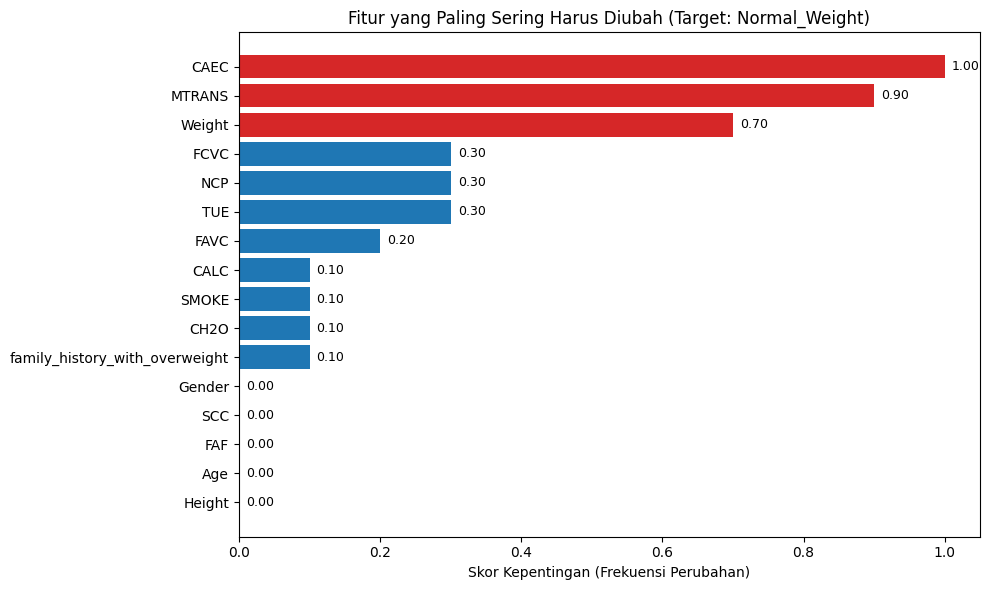


📊 **Interpretasi Hasil:**
1. Skor 1.0: Fitur ini WAJIB diubah di setiap skenario agar sehat.
2. Skor 0.0: Fitur ini sudah oke, tidak perlu diubah.
3. Fitur teratas adalah prioritas utama perubahan bagi pasien.


In [ ]:
def analisis_dice_importance(model, data_train, query_instance, target_class='Normal_Weight'):
    print(f"🔄 Sedang menghitung Feature Importance DiCE untuk target: {target_class}...")

    # 1. Siapkan Konfigurasi DiCE
    # Pisahkan nama target dan fitur kontinu
    target_name = 'NObeyesdad'
    continuous_features = data_train.select_dtypes(include=['number']).columns.tolist()
    if target_name in continuous_features:
        continuous_features.remove(target_name)

    # Setup Objek DiCE
    d = dice_ml.Data(dataframe=data_train,
                     continuous_features=continuous_features,
                     outcome_name=target_name)

    m = dice_ml.Model(model=model, backend="sklearn")

    # Gunakan method 'random' agar perhitungan importance lebih cepat dan beragam
    exp = dice_ml.Dice(d, m, method="genetic")

    # Mendapatkan daftar nama kelas dari model
    class_names = model.classes_.tolist()
    # Mencari indeks dari target_class yang diinginkan
    try:
        desired_class_index = class_names.index(target_class)
    except ValueError:
        print(f"❌ KESALAHAN: Kelas target '{target_class}' tidak ditemukan di daftar kelas model: {class_names}")
        return

    # Tentukan fitur yang tidak boleh diubah SAMA SEKALI
    # Menambahkan 'Age', 'Height', 'Weight', dan 'Gender' ke dalam fitur yang dikecualikan
    features_to_exclude_completely = ['Age', 'Height', 'Gender']

    # Buat permitted_range untuk fitur yang tidak boleh diubah
    permitted_range = {}
    for feature in features_to_exclude_completely:
        if feature in query_instance.columns:
            # Untuk fitur numerik, set range min dan max ke nilai saat ini
            if pd.api.types.is_numeric_dtype(query_instance[feature]):
                value = query_instance[feature].iloc[0]
                permitted_range[feature] = [value, value]
            # Untuk fitur kategorikal, set range ke nilai saat ini saja
            else:
                value = query_instance[feature].iloc[0]
                permitted_range[feature] = [value, value]

    # 2. Hitung Local Feature Importance
    # DiCE akan men-generate 10 contoh saran, lalu menghitung frekuensi perubahan fitur
    imp = exp.local_feature_importance(
        query_instance,
        total_CFs=10,
        desired_class=desired_class_index, # Menggunakan indeks kelas
        permitted_range=permitted_range # Menerapkan batasan
    )

    # 3. Olah Data untuk Visualisasi
    # Mengambil list of dictionaries importance (skor 0.0 s/d 1.0)
    importance_list = imp.local_importance

    # DEBUG: Cetak isi importance_list untuk memahami strukturnya
    print("DEBUG: importance_list content:", importance_list)

    # Perbaikan: Mengakses dictionary pertama dalam list dan mengurutkannya
    if importance_list and isinstance(importance_list[0], dict):
        # Convert the single dictionary into a list of (feature, score) tuples
        feature_scores = list(importance_list[0].items())
        # Sort this list of tuples by the score (second element) in descending order
        sorted_importance = sorted(feature_scores, key=lambda x: x[1], reverse=True)

        features = [item[0] for item in sorted_importance]
        scores = [item[1] for item in sorted_importance]
    else:
        print("❌ KESALAHAN: Struktur importance_list tidak seperti yang diharapkan.")
        return

    # 4. Tampilkan Visualisasi Bar Chart
    plt.figure(figsize=(10, 6))
    # Warna: Merah tua jika skor > 0.5 (Sangat Penting), Biru jika rendah
    colors = ['#d62728' if s > 0.5 else '#1f77b4' for s in scores]

    bars = plt.barh(features, scores, color=colors)
    plt.xlabel('Skor Kepentingan (Frekuensi Perubahan)')
    plt.title(f'Fitur yang Paling Sering Harus Diubah (Target: {target_class})')
    plt.gca().invert_yaxis() # Fitur terpenting di atas

    # Tambahkan label angka di batang
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width:.2f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n📊 **Interpretasi Hasil:**")
    print("1. Skor 1.0: Fitur ini WAJIB diubah di setiap skenario agar sehat.")
    print("2. Skor 0.0: Fitur ini sudah oke, tidak perlu diubah.")
    print(f"3. Fitur teratas adalah prioritas utama perubahan bagi pasien.")

# --- EKSEKUSI FUNGSI ---
# Pastikan variabel 'CatBoost_Model', 'combined_df', dan 'data_pasien_baru' sudah ada
if 'CatBoost_Model' in locals() and 'data_pasien_baru' in locals():
    # Kita gunakan combined_df sebagai data referensi (training data structure)
    # Pastikan data_pasien_baru memiliki kolom yang sama dengan X_train
    query_data = data_pasien_baru[X_train.columns]

    analisis_dice_importance(
        model=CatBoost_Model,
        data_train=combined_df,
        query_instance=query_data,
        target_class='Normal_Weight' # Target yang diinginkan
    )
else:
    print("❌ Error: Pastikan model dan data pasien sudah di-load sebelumnya.")

In [ ]:
CatBoost_Model.save_model('CatBoost_Model.cbm')
print("CatBoost_Model saved successfully as CatBoost_Model.cbm")

CatBoost_Model saved successfully as CatBoost_Model.cbm


In [ ]:
import joblib

# Menyimpan X_train_smote dan y_train_smote dalam format .pkl
joblib.dump(X_train_smote, 'X_train_smote.pkl')
joblib.dump(y_train_smote, 'y_train_smote.pkl')
print("X_train_smote dan y_train_smote berhasil disimpan dalam format .pkl")

X_train_smote dan y_train_smote berhasil disimpan dalam format .pkl
